In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

from abl.inflow.synthetic import TurbSim  # currently supported: TurbSim, GaborKS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
precdir = '/scratch/equon/precursors/neutral/8mps_rough0.15_6km_ds40'
bcname = 'west'
t0 = 50000.0 # end of precursor, beginning of finite-domain simulation
dt = 0.5 # fixed sampling period and finite-domain time-step size
ds = 10.0 # finite-domain resolution
domain_height = 1020.0
domain_width = 3000.0

# reference values
ustar = 0.423119
zhub = 90.0
Uhub = 8.0

# MMC params
#R13_ref = -ustar**2 # -4.50e-2 (from ds=20 case)
tanh_z50 = 625.0 # fluctuations from SGS KS constant up to z ~= 200
tanh_z90 = 645.0
tanh_z10 = tanh_z50 - (tanh_z90-tanh_z50)

# Read boundaryData from precursor

In [4]:
prec = np.load(os.path.join(precdir,'postProcessing','boundaryData',bcname,'data.npz'))
%time Uorig = np.copy(prec['U'])
%time Torig = np.copy(prec['T'])
%time korig = np.copy(prec['k'])

CPU times: user 37.1 s, sys: 4.49 s, total: 41.6 s
Wall time: 41.7 s
CPU times: user 6.62 s, sys: 874 ms, total: 7.5 s
Wall time: 7.5 s
CPU times: user 11.8 s, sys: 1.52 s, total: 13.3 s
Wall time: 13.3 s


In [5]:
plane = np.load(os.path.join(precdir,'postProcessing','boundaryData',bcname,'points.npz'))
%time ycc = np.copy(plane['y'])
%time zcc = np.copy(plane['z'])
dy = ycc[1,0] - ycc[0,0]
dz = zcc[0,1] - zcc[0,0]

CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 1.29 ms
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.36 ms


In [6]:
%time NT, NY, NZ, _ = Uorig.shape
print(NT,NY,NZ)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs
7200 300 102


In [7]:
t = t0 + np.arange(1,NT)*dt

# Read fluctuating velocity fields from TurbSim

In [9]:
%time sim = TurbSim('/projects/windsim/precursors/turbsim/neutral/ieckai_10m_8mps_11.5TI/ieckai', verbose=True)

Reading header information from /projects/windsim/precursors/turbsim/neutral/ieckai_10m_8mps_11.5TI/ieckai.bts
  id= 8 (periodic)
  NumGrid_Z,_Y= 76 76
  ntower= 0
  nt= 1200
  (problem size: 20793600 points)
  dz,dy= 10.0 10.0
  TimeStep= 0.5
  Period= 600.0
  Umean = uhub = 8.0 (for calculating fluctuations)
  HubHt= 380.0  (NOT USED)
  Zbottom= 5.0
  Vslope= [  7492.80761719   9124.65136719  14390.578125  ]
  Vintercept= [-61518.875       1437.140625    -246.8203125]
b'This full-field file was generated by TurbSim (v2.00.07a-bjj, 14-Jun-2016) on 11-Mar-2018 at 03:59:55.'
Reading normalized grid data
  U size : 79.3212890625 MB
  Read velocitiy fields in 39.8 s
Calculating velocities from normalized data
  u min/max [ -4.16287 4.58352 ]
  v min/max [ -3.74865 3.43354 ]
  w min/max [ -2.25989 2.29413 ]
Calculating coordinates
Read times [ 0.0 0.5 ... 599.5 ]
CPU times: user 40 s, sys: 44 ms, total: 40 s
Wall time: 40.2 s


In [10]:
# calculate "grid" for plotting (TurbSim)
sim.xG, sim.yG, sim.zG = np.meshgrid(Uhub*sim.t,sim.y,sim.z,indexing='ij')

In [11]:
sim.xG.shape

(1200, 76, 76)

(0.0, 4796.0, 0.0, 750.0)

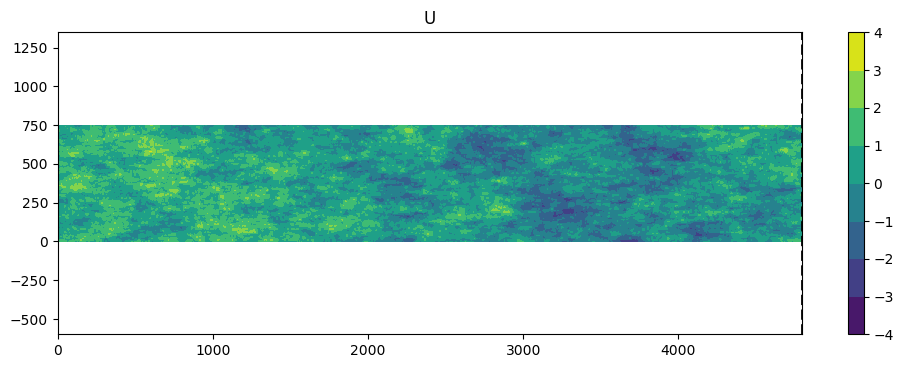

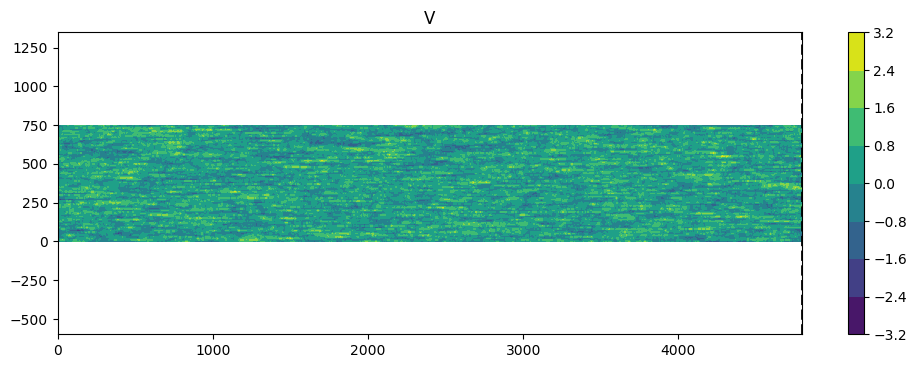

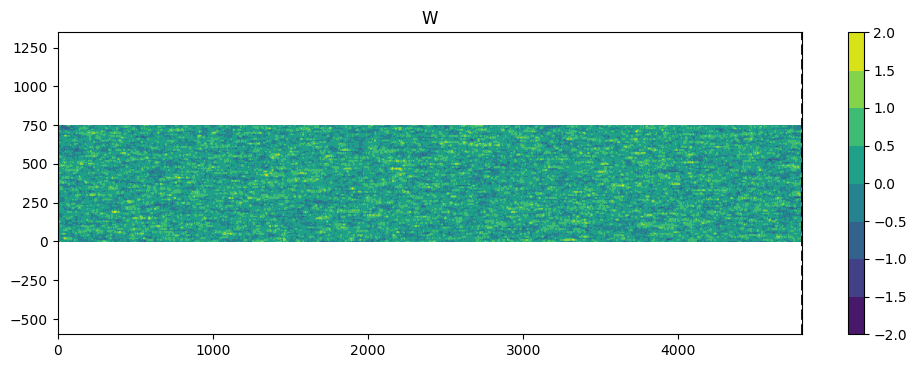

In [15]:
# plot horizontal slice of input field (t vs y)
zindex = 5
Tmax = None # 2000
period = np.max(sim.xG[:Tmax,:300,zindex])

fig,ax = plt.subplots(figsize=(12,4),dpi=100)
cnt = ax.contourf(sim.xG[:Tmax,:300,zindex], sim.yG[:Tmax,:300,zindex], sim.U[0,:Tmax,:300,zindex])
ax.axvline(period,color='k',lw=2,ls='--')
#cnt = ax.contourf(sim.xG[:Tmax,:300,zindex]+period, sim.yG[:Tmax,:300,zindex], sim.U[0,:Tmax,:300,zindex])
plt.colorbar(cnt)
ax.set_title('U')
plt.axis('equal')

fig,ax = plt.subplots(figsize=(12,4),dpi=100)
cnt = ax.contourf(sim.xG[:Tmax,:300,zindex], sim.yG[:Tmax,:300,zindex], sim.U[1,:Tmax,:300,zindex])
ax.axvline(period,color='k',lw=2,ls='--')
#cnt = ax.contourf(sim.xG[:Tmax,:300,zindex]+period, sim.yG[:Tmax,:300,zindex], sim.U[1,:Tmax,:300,zindex])
plt.colorbar(cnt)
ax.set_title('V')
plt.axis('equal')

fig,ax = plt.subplots(figsize=(12,4),dpi=100)
cnt = ax.contourf(sim.xG[:Tmax,:300,zindex], sim.yG[:Tmax,:300,zindex], sim.U[2,:Tmax,:300,zindex])
ax.axvline(period,color='k',lw=2,ls='--')
#cnt = ax.contourf(sim.xG[:Tmax,:300,zindex]+period, sim.yG[:Tmax,:300,zindex], sim.U[2,:Tmax,:300,zindex])
plt.colorbar(cnt)
ax.set_title('W')
plt.axis('equal')


In [16]:
# tile the domain (TurbSim only)
sim_width = np.max(sim.y) - np.min(sim.y)
ntiles = int(np.ceil(domain_width / sim_width))
print(ntiles,'tiles needed for simulated inflow plane width of',sim_width)
sim.tileY(ntiles=ntiles, mirror=True)

4 tiles needed for simulated inflow plane width of 750.0
Creating 4 horizontal tiles
  before: (3, 1200, 76, 76)
  after : (3, 1200, 301, 76)


In [17]:
# match sowfa inlet boundary
sim.resizeY(yMin=ds/2, yMax=domain_width-ds/2)
sim.resizeZ(zMin=ds/2, zMax=domain_height-ds/2)

Resizing fluctuations field in y-dir from [ 0.0 3000.0 ] to [ 5.0 2995.0 ]
  before: (3, 1200, 301, 76)
  after: (3, 1200, 300, 76)
Updating y coordinates
Resizing fluctuations field in z-dir from [ 5.0 755.0 ] to [ 5.0 1015.0 ]
  before: (3, 1200, 300, 76)
  after: (3, 1200, 300, 102)
Updating z coordinates
Resetting scaling function


In [18]:
# CHECK FOR DATA ALIGNMENT
checks = []
#checks.append(sim.NX >= NT)
checks.append(sim.NY >= NY)
checks.append(sim.NZ >= NZ)
checks.append(sim.dy == dy)
checks.append(sim.dz == dz)
checks.append(np.abs(sim.dt - dt) < 1e-8)
print(checks)

[True, True, True, True, True]


In [19]:
assert(all([stat==True for stat in checks]))

In [20]:
# ensure that we're using the exact dt we want
sim.dt = dt

In [21]:
sim.U.shape

(3, 1200, 300, 102)

Updated scaling range (dir=0) : 0.0 1.0
Updated scaling range (dir=1) : 0.0 1.0
Updated scaling range (dir=2) : 0.0 1.0


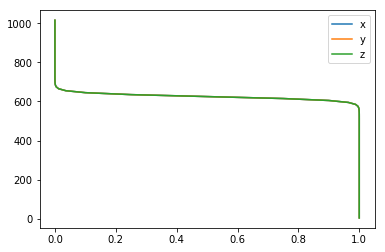

In [22]:
sim.set_scaling(
    tanh_z90=tanh_z90,
    tanh_z50=tanh_z50
)
plt.plot(sim.scaling[0,:],sim.z,label='x')
plt.plot(sim.scaling[1,:],sim.z,label='y')
plt.plot(sim.scaling[2,:],sim.z,label='z')
plt.legend(loc='best')

# GENERATE THE BOUNDARY DATA

In [23]:
# zero the inlet k
prec_mod = { 'U': Uorig, 'T': Torig, 'k': np.zeros(np.shape(Torig)) }

In [24]:
%time sim.write_sowfa_mapped_BC(outputdir='boundaryData',bcname='west',time_varying_input=prec_mod,tstart=t0,periodic=True)

Creating output dir : boundaryData/west
Writing boundaryData/west/points
Writing out boundaryData/west/50000.5/U
Writing out boundaryData/west/50000.5/T
Writing out boundaryData/west/50000.5/k
Writing out boundaryData/west/50001/U
Writing out boundaryData/west/50001/T
Writing out boundaryData/west/50001/k
Writing out boundaryData/west/50001.5/U
Writing out boundaryData/west/50001.5/T
Writing out boundaryData/west/50001.5/k
Writing out boundaryData/west/50002/U
Writing out boundaryData/west/50002/T
Writing out boundaryData/west/50002/k
Writing out boundaryData/west/50002.5/U
Writing out boundaryData/west/50002.5/T
Writing out boundaryData/west/50002.5/k
Writing out boundaryData/west/50003/U
Writing out boundaryData/west/50003/T
Writing out boundaryData/west/50003/k
Writing out boundaryData/west/50003.5/U
Writing out boundaryData/west/50003.5/T
Writing out boundaryData/west/50003.5/k
Writing out boundaryData/west/50004/U
Writing out boundaryData/west/50004/T
Writing out boundaryData/west

Writing out boundaryData/west/50035.5/U
Writing out boundaryData/west/50035.5/T
Writing out boundaryData/west/50035.5/k
Writing out boundaryData/west/50036/U
Writing out boundaryData/west/50036/T
Writing out boundaryData/west/50036/k
Writing out boundaryData/west/50036.5/U
Writing out boundaryData/west/50036.5/T
Writing out boundaryData/west/50036.5/k
Writing out boundaryData/west/50037/U
Writing out boundaryData/west/50037/T
Writing out boundaryData/west/50037/k
Writing out boundaryData/west/50037.5/U
Writing out boundaryData/west/50037.5/T
Writing out boundaryData/west/50037.5/k
Writing out boundaryData/west/50038/U
Writing out boundaryData/west/50038/T
Writing out boundaryData/west/50038/k
Writing out boundaryData/west/50038.5/U
Writing out boundaryData/west/50038.5/T
Writing out boundaryData/west/50038.5/k
Writing out boundaryData/west/50039/U
Writing out boundaryData/west/50039/T
Writing out boundaryData/west/50039/k
Writing out boundaryData/west/50039.5/U
Writing out boundaryData

Writing out boundaryData/west/50070.5/T
Writing out boundaryData/west/50070.5/k
Writing out boundaryData/west/50071/U
Writing out boundaryData/west/50071/T
Writing out boundaryData/west/50071/k
Writing out boundaryData/west/50071.5/U
Writing out boundaryData/west/50071.5/T
Writing out boundaryData/west/50071.5/k
Writing out boundaryData/west/50072/U
Writing out boundaryData/west/50072/T
Writing out boundaryData/west/50072/k
Writing out boundaryData/west/50072.5/U
Writing out boundaryData/west/50072.5/T
Writing out boundaryData/west/50072.5/k
Writing out boundaryData/west/50073/U
Writing out boundaryData/west/50073/T
Writing out boundaryData/west/50073/k
Writing out boundaryData/west/50073.5/U
Writing out boundaryData/west/50073.5/T
Writing out boundaryData/west/50073.5/k
Writing out boundaryData/west/50074/U
Writing out boundaryData/west/50074/T
Writing out boundaryData/west/50074/k
Writing out boundaryData/west/50074.5/U
Writing out boundaryData/west/50074.5/T
Writing out boundaryData

Writing out boundaryData/west/50106/U
Writing out boundaryData/west/50106/T
Writing out boundaryData/west/50106/k
Writing out boundaryData/west/50106.5/U
Writing out boundaryData/west/50106.5/T
Writing out boundaryData/west/50106.5/k
Writing out boundaryData/west/50107/U
Writing out boundaryData/west/50107/T
Writing out boundaryData/west/50107/k
Writing out boundaryData/west/50107.5/U
Writing out boundaryData/west/50107.5/T
Writing out boundaryData/west/50107.5/k
Writing out boundaryData/west/50108/U
Writing out boundaryData/west/50108/T
Writing out boundaryData/west/50108/k
Writing out boundaryData/west/50108.5/U
Writing out boundaryData/west/50108.5/T
Writing out boundaryData/west/50108.5/k
Writing out boundaryData/west/50109/U
Writing out boundaryData/west/50109/T
Writing out boundaryData/west/50109/k
Writing out boundaryData/west/50109.5/U
Writing out boundaryData/west/50109.5/T
Writing out boundaryData/west/50109.5/k
Writing out boundaryData/west/50110/U
Writing out boundaryData/w

Writing out boundaryData/west/50141/T
Writing out boundaryData/west/50141/k
Writing out boundaryData/west/50141.5/U
Writing out boundaryData/west/50141.5/T
Writing out boundaryData/west/50141.5/k
Writing out boundaryData/west/50142/U
Writing out boundaryData/west/50142/T
Writing out boundaryData/west/50142/k
Writing out boundaryData/west/50142.5/U
Writing out boundaryData/west/50142.5/T
Writing out boundaryData/west/50142.5/k
Writing out boundaryData/west/50143/U
Writing out boundaryData/west/50143/T
Writing out boundaryData/west/50143/k
Writing out boundaryData/west/50143.5/U
Writing out boundaryData/west/50143.5/T
Writing out boundaryData/west/50143.5/k
Writing out boundaryData/west/50144/U
Writing out boundaryData/west/50144/T
Writing out boundaryData/west/50144/k
Writing out boundaryData/west/50144.5/U
Writing out boundaryData/west/50144.5/T
Writing out boundaryData/west/50144.5/k
Writing out boundaryData/west/50145/U
Writing out boundaryData/west/50145/T
Writing out boundaryData/w

Writing out boundaryData/west/50176.5/U
Writing out boundaryData/west/50176.5/T
Writing out boundaryData/west/50176.5/k
Writing out boundaryData/west/50177/U
Writing out boundaryData/west/50177/T
Writing out boundaryData/west/50177/k
Writing out boundaryData/west/50177.5/U
Writing out boundaryData/west/50177.5/T
Writing out boundaryData/west/50177.5/k
Writing out boundaryData/west/50178/U
Writing out boundaryData/west/50178/T
Writing out boundaryData/west/50178/k
Writing out boundaryData/west/50178.5/U
Writing out boundaryData/west/50178.5/T
Writing out boundaryData/west/50178.5/k
Writing out boundaryData/west/50179/U
Writing out boundaryData/west/50179/T
Writing out boundaryData/west/50179/k
Writing out boundaryData/west/50179.5/U
Writing out boundaryData/west/50179.5/T
Writing out boundaryData/west/50179.5/k
Writing out boundaryData/west/50180/U
Writing out boundaryData/west/50180/T
Writing out boundaryData/west/50180/k
Writing out boundaryData/west/50180.5/U
Writing out boundaryData

Writing out boundaryData/west/50211.5/T
Writing out boundaryData/west/50211.5/k
Writing out boundaryData/west/50212/U
Writing out boundaryData/west/50212/T
Writing out boundaryData/west/50212/k
Writing out boundaryData/west/50212.5/U
Writing out boundaryData/west/50212.5/T
Writing out boundaryData/west/50212.5/k
Writing out boundaryData/west/50213/U
Writing out boundaryData/west/50213/T
Writing out boundaryData/west/50213/k
Writing out boundaryData/west/50213.5/U
Writing out boundaryData/west/50213.5/T
Writing out boundaryData/west/50213.5/k
Writing out boundaryData/west/50214/U
Writing out boundaryData/west/50214/T
Writing out boundaryData/west/50214/k
Writing out boundaryData/west/50214.5/U
Writing out boundaryData/west/50214.5/T
Writing out boundaryData/west/50214.5/k
Writing out boundaryData/west/50215/U
Writing out boundaryData/west/50215/T
Writing out boundaryData/west/50215/k
Writing out boundaryData/west/50215.5/U
Writing out boundaryData/west/50215.5/T
Writing out boundaryData

Writing out boundaryData/west/50247/U
Writing out boundaryData/west/50247/T
Writing out boundaryData/west/50247/k
Writing out boundaryData/west/50247.5/U
Writing out boundaryData/west/50247.5/T
Writing out boundaryData/west/50247.5/k
Writing out boundaryData/west/50248/U
Writing out boundaryData/west/50248/T
Writing out boundaryData/west/50248/k
Writing out boundaryData/west/50248.5/U
Writing out boundaryData/west/50248.5/T
Writing out boundaryData/west/50248.5/k
Writing out boundaryData/west/50249/U
Writing out boundaryData/west/50249/T
Writing out boundaryData/west/50249/k
Writing out boundaryData/west/50249.5/U
Writing out boundaryData/west/50249.5/T
Writing out boundaryData/west/50249.5/k
Writing out boundaryData/west/50250/U
Writing out boundaryData/west/50250/T
Writing out boundaryData/west/50250/k
Writing out boundaryData/west/50250.5/U
Writing out boundaryData/west/50250.5/T
Writing out boundaryData/west/50250.5/k
Writing out boundaryData/west/50251/U
Writing out boundaryData/w

Writing out boundaryData/west/50282/T
Writing out boundaryData/west/50282/k
Writing out boundaryData/west/50282.5/U
Writing out boundaryData/west/50282.5/T
Writing out boundaryData/west/50282.5/k
Writing out boundaryData/west/50283/U
Writing out boundaryData/west/50283/T
Writing out boundaryData/west/50283/k
Writing out boundaryData/west/50283.5/U
Writing out boundaryData/west/50283.5/T
Writing out boundaryData/west/50283.5/k
Writing out boundaryData/west/50284/U
Writing out boundaryData/west/50284/T
Writing out boundaryData/west/50284/k
Writing out boundaryData/west/50284.5/U
Writing out boundaryData/west/50284.5/T
Writing out boundaryData/west/50284.5/k
Writing out boundaryData/west/50285/U
Writing out boundaryData/west/50285/T
Writing out boundaryData/west/50285/k
Writing out boundaryData/west/50285.5/U
Writing out boundaryData/west/50285.5/T
Writing out boundaryData/west/50285.5/k
Writing out boundaryData/west/50286/U
Writing out boundaryData/west/50286/T
Writing out boundaryData/w

Writing out boundaryData/west/50317.5/U
Writing out boundaryData/west/50317.5/T
Writing out boundaryData/west/50317.5/k
Writing out boundaryData/west/50318/U
Writing out boundaryData/west/50318/T
Writing out boundaryData/west/50318/k
Writing out boundaryData/west/50318.5/U
Writing out boundaryData/west/50318.5/T
Writing out boundaryData/west/50318.5/k
Writing out boundaryData/west/50319/U
Writing out boundaryData/west/50319/T
Writing out boundaryData/west/50319/k
Writing out boundaryData/west/50319.5/U
Writing out boundaryData/west/50319.5/T
Writing out boundaryData/west/50319.5/k
Writing out boundaryData/west/50320/U
Writing out boundaryData/west/50320/T
Writing out boundaryData/west/50320/k
Writing out boundaryData/west/50320.5/U
Writing out boundaryData/west/50320.5/T
Writing out boundaryData/west/50320.5/k
Writing out boundaryData/west/50321/U
Writing out boundaryData/west/50321/T
Writing out boundaryData/west/50321/k
Writing out boundaryData/west/50321.5/U
Writing out boundaryData

Writing out boundaryData/west/50352.5/T
Writing out boundaryData/west/50352.5/k
Writing out boundaryData/west/50353/U
Writing out boundaryData/west/50353/T
Writing out boundaryData/west/50353/k
Writing out boundaryData/west/50353.5/U
Writing out boundaryData/west/50353.5/T
Writing out boundaryData/west/50353.5/k
Writing out boundaryData/west/50354/U
Writing out boundaryData/west/50354/T
Writing out boundaryData/west/50354/k
Writing out boundaryData/west/50354.5/U
Writing out boundaryData/west/50354.5/T
Writing out boundaryData/west/50354.5/k
Writing out boundaryData/west/50355/U
Writing out boundaryData/west/50355/T
Writing out boundaryData/west/50355/k
Writing out boundaryData/west/50355.5/U
Writing out boundaryData/west/50355.5/T
Writing out boundaryData/west/50355.5/k
Writing out boundaryData/west/50356/U
Writing out boundaryData/west/50356/T
Writing out boundaryData/west/50356/k
Writing out boundaryData/west/50356.5/U
Writing out boundaryData/west/50356.5/T
Writing out boundaryData

Writing out boundaryData/west/50388/U
Writing out boundaryData/west/50388/T
Writing out boundaryData/west/50388/k
Writing out boundaryData/west/50388.5/U
Writing out boundaryData/west/50388.5/T
Writing out boundaryData/west/50388.5/k
Writing out boundaryData/west/50389/U
Writing out boundaryData/west/50389/T
Writing out boundaryData/west/50389/k
Writing out boundaryData/west/50389.5/U
Writing out boundaryData/west/50389.5/T
Writing out boundaryData/west/50389.5/k
Writing out boundaryData/west/50390/U
Writing out boundaryData/west/50390/T
Writing out boundaryData/west/50390/k
Writing out boundaryData/west/50390.5/U
Writing out boundaryData/west/50390.5/T
Writing out boundaryData/west/50390.5/k
Writing out boundaryData/west/50391/U
Writing out boundaryData/west/50391/T
Writing out boundaryData/west/50391/k
Writing out boundaryData/west/50391.5/U
Writing out boundaryData/west/50391.5/T
Writing out boundaryData/west/50391.5/k
Writing out boundaryData/west/50392/U
Writing out boundaryData/w

Writing out boundaryData/west/50423/T
Writing out boundaryData/west/50423/k
Writing out boundaryData/west/50423.5/U
Writing out boundaryData/west/50423.5/T
Writing out boundaryData/west/50423.5/k
Writing out boundaryData/west/50424/U
Writing out boundaryData/west/50424/T
Writing out boundaryData/west/50424/k
Writing out boundaryData/west/50424.5/U
Writing out boundaryData/west/50424.5/T
Writing out boundaryData/west/50424.5/k
Writing out boundaryData/west/50425/U
Writing out boundaryData/west/50425/T
Writing out boundaryData/west/50425/k
Writing out boundaryData/west/50425.5/U
Writing out boundaryData/west/50425.5/T
Writing out boundaryData/west/50425.5/k
Writing out boundaryData/west/50426/U
Writing out boundaryData/west/50426/T
Writing out boundaryData/west/50426/k
Writing out boundaryData/west/50426.5/U
Writing out boundaryData/west/50426.5/T
Writing out boundaryData/west/50426.5/k
Writing out boundaryData/west/50427/U
Writing out boundaryData/west/50427/T
Writing out boundaryData/w

Writing out boundaryData/west/50458.5/U
Writing out boundaryData/west/50458.5/T
Writing out boundaryData/west/50458.5/k
Writing out boundaryData/west/50459/U
Writing out boundaryData/west/50459/T
Writing out boundaryData/west/50459/k
Writing out boundaryData/west/50459.5/U
Writing out boundaryData/west/50459.5/T
Writing out boundaryData/west/50459.5/k
Writing out boundaryData/west/50460/U
Writing out boundaryData/west/50460/T
Writing out boundaryData/west/50460/k
Writing out boundaryData/west/50460.5/U
Writing out boundaryData/west/50460.5/T
Writing out boundaryData/west/50460.5/k
Writing out boundaryData/west/50461/U
Writing out boundaryData/west/50461/T
Writing out boundaryData/west/50461/k
Writing out boundaryData/west/50461.5/U
Writing out boundaryData/west/50461.5/T
Writing out boundaryData/west/50461.5/k
Writing out boundaryData/west/50462/U
Writing out boundaryData/west/50462/T
Writing out boundaryData/west/50462/k
Writing out boundaryData/west/50462.5/U
Writing out boundaryData

Writing out boundaryData/west/50493.5/T
Writing out boundaryData/west/50493.5/k
Writing out boundaryData/west/50494/U
Writing out boundaryData/west/50494/T
Writing out boundaryData/west/50494/k
Writing out boundaryData/west/50494.5/U
Writing out boundaryData/west/50494.5/T
Writing out boundaryData/west/50494.5/k
Writing out boundaryData/west/50495/U
Writing out boundaryData/west/50495/T
Writing out boundaryData/west/50495/k
Writing out boundaryData/west/50495.5/U
Writing out boundaryData/west/50495.5/T
Writing out boundaryData/west/50495.5/k
Writing out boundaryData/west/50496/U
Writing out boundaryData/west/50496/T
Writing out boundaryData/west/50496/k
Writing out boundaryData/west/50496.5/U
Writing out boundaryData/west/50496.5/T
Writing out boundaryData/west/50496.5/k
Writing out boundaryData/west/50497/U
Writing out boundaryData/west/50497/T
Writing out boundaryData/west/50497/k
Writing out boundaryData/west/50497.5/U
Writing out boundaryData/west/50497.5/T
Writing out boundaryData

Writing out boundaryData/west/50529/U
Writing out boundaryData/west/50529/T
Writing out boundaryData/west/50529/k
Writing out boundaryData/west/50529.5/U
Writing out boundaryData/west/50529.5/T
Writing out boundaryData/west/50529.5/k
Writing out boundaryData/west/50530/U
Writing out boundaryData/west/50530/T
Writing out boundaryData/west/50530/k
Writing out boundaryData/west/50530.5/U
Writing out boundaryData/west/50530.5/T
Writing out boundaryData/west/50530.5/k
Writing out boundaryData/west/50531/U
Writing out boundaryData/west/50531/T
Writing out boundaryData/west/50531/k
Writing out boundaryData/west/50531.5/U
Writing out boundaryData/west/50531.5/T
Writing out boundaryData/west/50531.5/k
Writing out boundaryData/west/50532/U
Writing out boundaryData/west/50532/T
Writing out boundaryData/west/50532/k
Writing out boundaryData/west/50532.5/U
Writing out boundaryData/west/50532.5/T
Writing out boundaryData/west/50532.5/k
Writing out boundaryData/west/50533/U
Writing out boundaryData/w

Writing out boundaryData/west/50564/T
Writing out boundaryData/west/50564/k
Writing out boundaryData/west/50564.5/U
Writing out boundaryData/west/50564.5/T
Writing out boundaryData/west/50564.5/k
Writing out boundaryData/west/50565/U
Writing out boundaryData/west/50565/T
Writing out boundaryData/west/50565/k
Writing out boundaryData/west/50565.5/U
Writing out boundaryData/west/50565.5/T
Writing out boundaryData/west/50565.5/k
Writing out boundaryData/west/50566/U
Writing out boundaryData/west/50566/T
Writing out boundaryData/west/50566/k
Writing out boundaryData/west/50566.5/U
Writing out boundaryData/west/50566.5/T
Writing out boundaryData/west/50566.5/k
Writing out boundaryData/west/50567/U
Writing out boundaryData/west/50567/T
Writing out boundaryData/west/50567/k
Writing out boundaryData/west/50567.5/U
Writing out boundaryData/west/50567.5/T
Writing out boundaryData/west/50567.5/k
Writing out boundaryData/west/50568/U
Writing out boundaryData/west/50568/T
Writing out boundaryData/w

Writing out boundaryData/west/50599.5/U
Writing out boundaryData/west/50599.5/T
Writing out boundaryData/west/50599.5/k
Writing out boundaryData/west/50600/U
Writing out boundaryData/west/50600/T
Writing out boundaryData/west/50600/k
Writing out boundaryData/west/50600.5/U
Writing out boundaryData/west/50600.5/T
Writing out boundaryData/west/50600.5/k
Writing out boundaryData/west/50601/U
Writing out boundaryData/west/50601/T
Writing out boundaryData/west/50601/k
Writing out boundaryData/west/50601.5/U
Writing out boundaryData/west/50601.5/T
Writing out boundaryData/west/50601.5/k
Writing out boundaryData/west/50602/U
Writing out boundaryData/west/50602/T
Writing out boundaryData/west/50602/k
Writing out boundaryData/west/50602.5/U
Writing out boundaryData/west/50602.5/T
Writing out boundaryData/west/50602.5/k
Writing out boundaryData/west/50603/U
Writing out boundaryData/west/50603/T
Writing out boundaryData/west/50603/k
Writing out boundaryData/west/50603.5/U
Writing out boundaryData

Writing out boundaryData/west/50634.5/T
Writing out boundaryData/west/50634.5/k
Writing out boundaryData/west/50635/U
Writing out boundaryData/west/50635/T
Writing out boundaryData/west/50635/k
Writing out boundaryData/west/50635.5/U
Writing out boundaryData/west/50635.5/T
Writing out boundaryData/west/50635.5/k
Writing out boundaryData/west/50636/U
Writing out boundaryData/west/50636/T
Writing out boundaryData/west/50636/k
Writing out boundaryData/west/50636.5/U
Writing out boundaryData/west/50636.5/T
Writing out boundaryData/west/50636.5/k
Writing out boundaryData/west/50637/U
Writing out boundaryData/west/50637/T
Writing out boundaryData/west/50637/k
Writing out boundaryData/west/50637.5/U
Writing out boundaryData/west/50637.5/T
Writing out boundaryData/west/50637.5/k
Writing out boundaryData/west/50638/U
Writing out boundaryData/west/50638/T
Writing out boundaryData/west/50638/k
Writing out boundaryData/west/50638.5/U
Writing out boundaryData/west/50638.5/T
Writing out boundaryData

Writing out boundaryData/west/50670/U
Writing out boundaryData/west/50670/T
Writing out boundaryData/west/50670/k
Writing out boundaryData/west/50670.5/U
Writing out boundaryData/west/50670.5/T
Writing out boundaryData/west/50670.5/k
Writing out boundaryData/west/50671/U
Writing out boundaryData/west/50671/T
Writing out boundaryData/west/50671/k
Writing out boundaryData/west/50671.5/U
Writing out boundaryData/west/50671.5/T
Writing out boundaryData/west/50671.5/k
Writing out boundaryData/west/50672/U
Writing out boundaryData/west/50672/T
Writing out boundaryData/west/50672/k
Writing out boundaryData/west/50672.5/U
Writing out boundaryData/west/50672.5/T
Writing out boundaryData/west/50672.5/k
Writing out boundaryData/west/50673/U
Writing out boundaryData/west/50673/T
Writing out boundaryData/west/50673/k
Writing out boundaryData/west/50673.5/U
Writing out boundaryData/west/50673.5/T
Writing out boundaryData/west/50673.5/k
Writing out boundaryData/west/50674/U
Writing out boundaryData/w

Writing out boundaryData/west/50705/T
Writing out boundaryData/west/50705/k
Writing out boundaryData/west/50705.5/U
Writing out boundaryData/west/50705.5/T
Writing out boundaryData/west/50705.5/k
Writing out boundaryData/west/50706/U
Writing out boundaryData/west/50706/T
Writing out boundaryData/west/50706/k
Writing out boundaryData/west/50706.5/U
Writing out boundaryData/west/50706.5/T
Writing out boundaryData/west/50706.5/k
Writing out boundaryData/west/50707/U
Writing out boundaryData/west/50707/T
Writing out boundaryData/west/50707/k
Writing out boundaryData/west/50707.5/U
Writing out boundaryData/west/50707.5/T
Writing out boundaryData/west/50707.5/k
Writing out boundaryData/west/50708/U
Writing out boundaryData/west/50708/T
Writing out boundaryData/west/50708/k
Writing out boundaryData/west/50708.5/U
Writing out boundaryData/west/50708.5/T
Writing out boundaryData/west/50708.5/k
Writing out boundaryData/west/50709/U
Writing out boundaryData/west/50709/T
Writing out boundaryData/w

Writing out boundaryData/west/50740.5/U
Writing out boundaryData/west/50740.5/T
Writing out boundaryData/west/50740.5/k
Writing out boundaryData/west/50741/U
Writing out boundaryData/west/50741/T
Writing out boundaryData/west/50741/k
Writing out boundaryData/west/50741.5/U
Writing out boundaryData/west/50741.5/T
Writing out boundaryData/west/50741.5/k
Writing out boundaryData/west/50742/U
Writing out boundaryData/west/50742/T
Writing out boundaryData/west/50742/k
Writing out boundaryData/west/50742.5/U
Writing out boundaryData/west/50742.5/T
Writing out boundaryData/west/50742.5/k
Writing out boundaryData/west/50743/U
Writing out boundaryData/west/50743/T
Writing out boundaryData/west/50743/k
Writing out boundaryData/west/50743.5/U
Writing out boundaryData/west/50743.5/T
Writing out boundaryData/west/50743.5/k
Writing out boundaryData/west/50744/U
Writing out boundaryData/west/50744/T
Writing out boundaryData/west/50744/k
Writing out boundaryData/west/50744.5/U
Writing out boundaryData

Writing out boundaryData/west/50775.5/T
Writing out boundaryData/west/50775.5/k
Writing out boundaryData/west/50776/U
Writing out boundaryData/west/50776/T
Writing out boundaryData/west/50776/k
Writing out boundaryData/west/50776.5/U
Writing out boundaryData/west/50776.5/T
Writing out boundaryData/west/50776.5/k
Writing out boundaryData/west/50777/U
Writing out boundaryData/west/50777/T
Writing out boundaryData/west/50777/k
Writing out boundaryData/west/50777.5/U
Writing out boundaryData/west/50777.5/T
Writing out boundaryData/west/50777.5/k
Writing out boundaryData/west/50778/U
Writing out boundaryData/west/50778/T
Writing out boundaryData/west/50778/k
Writing out boundaryData/west/50778.5/U
Writing out boundaryData/west/50778.5/T
Writing out boundaryData/west/50778.5/k
Writing out boundaryData/west/50779/U
Writing out boundaryData/west/50779/T
Writing out boundaryData/west/50779/k
Writing out boundaryData/west/50779.5/U
Writing out boundaryData/west/50779.5/T
Writing out boundaryData

Writing out boundaryData/west/50811/U
Writing out boundaryData/west/50811/T
Writing out boundaryData/west/50811/k
Writing out boundaryData/west/50811.5/U
Writing out boundaryData/west/50811.5/T
Writing out boundaryData/west/50811.5/k
Writing out boundaryData/west/50812/U
Writing out boundaryData/west/50812/T
Writing out boundaryData/west/50812/k
Writing out boundaryData/west/50812.5/U
Writing out boundaryData/west/50812.5/T
Writing out boundaryData/west/50812.5/k
Writing out boundaryData/west/50813/U
Writing out boundaryData/west/50813/T
Writing out boundaryData/west/50813/k
Writing out boundaryData/west/50813.5/U
Writing out boundaryData/west/50813.5/T
Writing out boundaryData/west/50813.5/k
Writing out boundaryData/west/50814/U
Writing out boundaryData/west/50814/T
Writing out boundaryData/west/50814/k
Writing out boundaryData/west/50814.5/U
Writing out boundaryData/west/50814.5/T
Writing out boundaryData/west/50814.5/k
Writing out boundaryData/west/50815/U
Writing out boundaryData/w

Writing out boundaryData/west/50846/T
Writing out boundaryData/west/50846/k
Writing out boundaryData/west/50846.5/U
Writing out boundaryData/west/50846.5/T
Writing out boundaryData/west/50846.5/k
Writing out boundaryData/west/50847/U
Writing out boundaryData/west/50847/T
Writing out boundaryData/west/50847/k
Writing out boundaryData/west/50847.5/U
Writing out boundaryData/west/50847.5/T
Writing out boundaryData/west/50847.5/k
Writing out boundaryData/west/50848/U
Writing out boundaryData/west/50848/T
Writing out boundaryData/west/50848/k
Writing out boundaryData/west/50848.5/U
Writing out boundaryData/west/50848.5/T
Writing out boundaryData/west/50848.5/k
Writing out boundaryData/west/50849/U
Writing out boundaryData/west/50849/T
Writing out boundaryData/west/50849/k
Writing out boundaryData/west/50849.5/U
Writing out boundaryData/west/50849.5/T
Writing out boundaryData/west/50849.5/k
Writing out boundaryData/west/50850/U
Writing out boundaryData/west/50850/T
Writing out boundaryData/w

Writing out boundaryData/west/50881.5/U
Writing out boundaryData/west/50881.5/T
Writing out boundaryData/west/50881.5/k
Writing out boundaryData/west/50882/U
Writing out boundaryData/west/50882/T
Writing out boundaryData/west/50882/k
Writing out boundaryData/west/50882.5/U
Writing out boundaryData/west/50882.5/T
Writing out boundaryData/west/50882.5/k
Writing out boundaryData/west/50883/U
Writing out boundaryData/west/50883/T
Writing out boundaryData/west/50883/k
Writing out boundaryData/west/50883.5/U
Writing out boundaryData/west/50883.5/T
Writing out boundaryData/west/50883.5/k
Writing out boundaryData/west/50884/U
Writing out boundaryData/west/50884/T
Writing out boundaryData/west/50884/k
Writing out boundaryData/west/50884.5/U
Writing out boundaryData/west/50884.5/T
Writing out boundaryData/west/50884.5/k
Writing out boundaryData/west/50885/U
Writing out boundaryData/west/50885/T
Writing out boundaryData/west/50885/k
Writing out boundaryData/west/50885.5/U
Writing out boundaryData

Writing out boundaryData/west/50916.5/T
Writing out boundaryData/west/50916.5/k
Writing out boundaryData/west/50917/U
Writing out boundaryData/west/50917/T
Writing out boundaryData/west/50917/k
Writing out boundaryData/west/50917.5/U
Writing out boundaryData/west/50917.5/T
Writing out boundaryData/west/50917.5/k
Writing out boundaryData/west/50918/U
Writing out boundaryData/west/50918/T
Writing out boundaryData/west/50918/k
Writing out boundaryData/west/50918.5/U
Writing out boundaryData/west/50918.5/T
Writing out boundaryData/west/50918.5/k
Writing out boundaryData/west/50919/U
Writing out boundaryData/west/50919/T
Writing out boundaryData/west/50919/k
Writing out boundaryData/west/50919.5/U
Writing out boundaryData/west/50919.5/T
Writing out boundaryData/west/50919.5/k
Writing out boundaryData/west/50920/U
Writing out boundaryData/west/50920/T
Writing out boundaryData/west/50920/k
Writing out boundaryData/west/50920.5/U
Writing out boundaryData/west/50920.5/T
Writing out boundaryData

Writing out boundaryData/west/50952/U
Writing out boundaryData/west/50952/T
Writing out boundaryData/west/50952/k
Writing out boundaryData/west/50952.5/U
Writing out boundaryData/west/50952.5/T
Writing out boundaryData/west/50952.5/k
Writing out boundaryData/west/50953/U
Writing out boundaryData/west/50953/T
Writing out boundaryData/west/50953/k
Writing out boundaryData/west/50953.5/U
Writing out boundaryData/west/50953.5/T
Writing out boundaryData/west/50953.5/k
Writing out boundaryData/west/50954/U
Writing out boundaryData/west/50954/T
Writing out boundaryData/west/50954/k
Writing out boundaryData/west/50954.5/U
Writing out boundaryData/west/50954.5/T
Writing out boundaryData/west/50954.5/k
Writing out boundaryData/west/50955/U
Writing out boundaryData/west/50955/T
Writing out boundaryData/west/50955/k
Writing out boundaryData/west/50955.5/U
Writing out boundaryData/west/50955.5/T
Writing out boundaryData/west/50955.5/k
Writing out boundaryData/west/50956/U
Writing out boundaryData/w

Writing out boundaryData/west/50987/T
Writing out boundaryData/west/50987/k
Writing out boundaryData/west/50987.5/U
Writing out boundaryData/west/50987.5/T
Writing out boundaryData/west/50987.5/k
Writing out boundaryData/west/50988/U
Writing out boundaryData/west/50988/T
Writing out boundaryData/west/50988/k
Writing out boundaryData/west/50988.5/U
Writing out boundaryData/west/50988.5/T
Writing out boundaryData/west/50988.5/k
Writing out boundaryData/west/50989/U
Writing out boundaryData/west/50989/T
Writing out boundaryData/west/50989/k
Writing out boundaryData/west/50989.5/U
Writing out boundaryData/west/50989.5/T
Writing out boundaryData/west/50989.5/k
Writing out boundaryData/west/50990/U
Writing out boundaryData/west/50990/T
Writing out boundaryData/west/50990/k
Writing out boundaryData/west/50990.5/U
Writing out boundaryData/west/50990.5/T
Writing out boundaryData/west/50990.5/k
Writing out boundaryData/west/50991/U
Writing out boundaryData/west/50991/T
Writing out boundaryData/w

Writing out boundaryData/west/51022.5/U
Writing out boundaryData/west/51022.5/T
Writing out boundaryData/west/51022.5/k
Writing out boundaryData/west/51023/U
Writing out boundaryData/west/51023/T
Writing out boundaryData/west/51023/k
Writing out boundaryData/west/51023.5/U
Writing out boundaryData/west/51023.5/T
Writing out boundaryData/west/51023.5/k
Writing out boundaryData/west/51024/U
Writing out boundaryData/west/51024/T
Writing out boundaryData/west/51024/k
Writing out boundaryData/west/51024.5/U
Writing out boundaryData/west/51024.5/T
Writing out boundaryData/west/51024.5/k
Writing out boundaryData/west/51025/U
Writing out boundaryData/west/51025/T
Writing out boundaryData/west/51025/k
Writing out boundaryData/west/51025.5/U
Writing out boundaryData/west/51025.5/T
Writing out boundaryData/west/51025.5/k
Writing out boundaryData/west/51026/U
Writing out boundaryData/west/51026/T
Writing out boundaryData/west/51026/k
Writing out boundaryData/west/51026.5/U
Writing out boundaryData

Writing out boundaryData/west/51057.5/T
Writing out boundaryData/west/51057.5/k
Writing out boundaryData/west/51058/U
Writing out boundaryData/west/51058/T
Writing out boundaryData/west/51058/k
Writing out boundaryData/west/51058.5/U
Writing out boundaryData/west/51058.5/T
Writing out boundaryData/west/51058.5/k
Writing out boundaryData/west/51059/U
Writing out boundaryData/west/51059/T
Writing out boundaryData/west/51059/k
Writing out boundaryData/west/51059.5/U
Writing out boundaryData/west/51059.5/T
Writing out boundaryData/west/51059.5/k
Writing out boundaryData/west/51060/U
Writing out boundaryData/west/51060/T
Writing out boundaryData/west/51060/k
Writing out boundaryData/west/51060.5/U
Writing out boundaryData/west/51060.5/T
Writing out boundaryData/west/51060.5/k
Writing out boundaryData/west/51061/U
Writing out boundaryData/west/51061/T
Writing out boundaryData/west/51061/k
Writing out boundaryData/west/51061.5/U
Writing out boundaryData/west/51061.5/T
Writing out boundaryData

Writing out boundaryData/west/51093/U
Writing out boundaryData/west/51093/T
Writing out boundaryData/west/51093/k
Writing out boundaryData/west/51093.5/U
Writing out boundaryData/west/51093.5/T
Writing out boundaryData/west/51093.5/k
Writing out boundaryData/west/51094/U
Writing out boundaryData/west/51094/T
Writing out boundaryData/west/51094/k
Writing out boundaryData/west/51094.5/U
Writing out boundaryData/west/51094.5/T
Writing out boundaryData/west/51094.5/k
Writing out boundaryData/west/51095/U
Writing out boundaryData/west/51095/T
Writing out boundaryData/west/51095/k
Writing out boundaryData/west/51095.5/U
Writing out boundaryData/west/51095.5/T
Writing out boundaryData/west/51095.5/k
Writing out boundaryData/west/51096/U
Writing out boundaryData/west/51096/T
Writing out boundaryData/west/51096/k
Writing out boundaryData/west/51096.5/U
Writing out boundaryData/west/51096.5/T
Writing out boundaryData/west/51096.5/k
Writing out boundaryData/west/51097/U
Writing out boundaryData/w

Writing out boundaryData/west/51128/T
Writing out boundaryData/west/51128/k
Writing out boundaryData/west/51128.5/U
Writing out boundaryData/west/51128.5/T
Writing out boundaryData/west/51128.5/k
Writing out boundaryData/west/51129/U
Writing out boundaryData/west/51129/T
Writing out boundaryData/west/51129/k
Writing out boundaryData/west/51129.5/U
Writing out boundaryData/west/51129.5/T
Writing out boundaryData/west/51129.5/k
Writing out boundaryData/west/51130/U
Writing out boundaryData/west/51130/T
Writing out boundaryData/west/51130/k
Writing out boundaryData/west/51130.5/U
Writing out boundaryData/west/51130.5/T
Writing out boundaryData/west/51130.5/k
Writing out boundaryData/west/51131/U
Writing out boundaryData/west/51131/T
Writing out boundaryData/west/51131/k
Writing out boundaryData/west/51131.5/U
Writing out boundaryData/west/51131.5/T
Writing out boundaryData/west/51131.5/k
Writing out boundaryData/west/51132/U
Writing out boundaryData/west/51132/T
Writing out boundaryData/w

Writing out boundaryData/west/51163.5/U
Writing out boundaryData/west/51163.5/T
Writing out boundaryData/west/51163.5/k
Writing out boundaryData/west/51164/U
Writing out boundaryData/west/51164/T
Writing out boundaryData/west/51164/k
Writing out boundaryData/west/51164.5/U
Writing out boundaryData/west/51164.5/T
Writing out boundaryData/west/51164.5/k
Writing out boundaryData/west/51165/U
Writing out boundaryData/west/51165/T
Writing out boundaryData/west/51165/k
Writing out boundaryData/west/51165.5/U
Writing out boundaryData/west/51165.5/T
Writing out boundaryData/west/51165.5/k
Writing out boundaryData/west/51166/U
Writing out boundaryData/west/51166/T
Writing out boundaryData/west/51166/k
Writing out boundaryData/west/51166.5/U
Writing out boundaryData/west/51166.5/T
Writing out boundaryData/west/51166.5/k
Writing out boundaryData/west/51167/U
Writing out boundaryData/west/51167/T
Writing out boundaryData/west/51167/k
Writing out boundaryData/west/51167.5/U
Writing out boundaryData

Writing out boundaryData/west/51198.5/T
Writing out boundaryData/west/51198.5/k
Writing out boundaryData/west/51199/U
Writing out boundaryData/west/51199/T
Writing out boundaryData/west/51199/k
Writing out boundaryData/west/51199.5/U
Writing out boundaryData/west/51199.5/T
Writing out boundaryData/west/51199.5/k
Writing out boundaryData/west/51200/U
Writing out boundaryData/west/51200/T
Writing out boundaryData/west/51200/k
Writing out boundaryData/west/51200.5/U
Writing out boundaryData/west/51200.5/T
Writing out boundaryData/west/51200.5/k
Writing out boundaryData/west/51201/U
Writing out boundaryData/west/51201/T
Writing out boundaryData/west/51201/k
Writing out boundaryData/west/51201.5/U
Writing out boundaryData/west/51201.5/T
Writing out boundaryData/west/51201.5/k
Writing out boundaryData/west/51202/U
Writing out boundaryData/west/51202/T
Writing out boundaryData/west/51202/k
Writing out boundaryData/west/51202.5/U
Writing out boundaryData/west/51202.5/T
Writing out boundaryData

Writing out boundaryData/west/51234/U
Writing out boundaryData/west/51234/T
Writing out boundaryData/west/51234/k
Writing out boundaryData/west/51234.5/U
Writing out boundaryData/west/51234.5/T
Writing out boundaryData/west/51234.5/k
Writing out boundaryData/west/51235/U
Writing out boundaryData/west/51235/T
Writing out boundaryData/west/51235/k
Writing out boundaryData/west/51235.5/U
Writing out boundaryData/west/51235.5/T
Writing out boundaryData/west/51235.5/k
Writing out boundaryData/west/51236/U
Writing out boundaryData/west/51236/T
Writing out boundaryData/west/51236/k
Writing out boundaryData/west/51236.5/U
Writing out boundaryData/west/51236.5/T
Writing out boundaryData/west/51236.5/k
Writing out boundaryData/west/51237/U
Writing out boundaryData/west/51237/T
Writing out boundaryData/west/51237/k
Writing out boundaryData/west/51237.5/U
Writing out boundaryData/west/51237.5/T
Writing out boundaryData/west/51237.5/k
Writing out boundaryData/west/51238/U
Writing out boundaryData/w

Writing out boundaryData/west/51269/T
Writing out boundaryData/west/51269/k
Writing out boundaryData/west/51269.5/U
Writing out boundaryData/west/51269.5/T
Writing out boundaryData/west/51269.5/k
Writing out boundaryData/west/51270/U
Writing out boundaryData/west/51270/T
Writing out boundaryData/west/51270/k
Writing out boundaryData/west/51270.5/U
Writing out boundaryData/west/51270.5/T
Writing out boundaryData/west/51270.5/k
Writing out boundaryData/west/51271/U
Writing out boundaryData/west/51271/T
Writing out boundaryData/west/51271/k
Writing out boundaryData/west/51271.5/U
Writing out boundaryData/west/51271.5/T
Writing out boundaryData/west/51271.5/k
Writing out boundaryData/west/51272/U
Writing out boundaryData/west/51272/T
Writing out boundaryData/west/51272/k
Writing out boundaryData/west/51272.5/U
Writing out boundaryData/west/51272.5/T
Writing out boundaryData/west/51272.5/k
Writing out boundaryData/west/51273/U
Writing out boundaryData/west/51273/T
Writing out boundaryData/w

Writing out boundaryData/west/51304.5/U
Writing out boundaryData/west/51304.5/T
Writing out boundaryData/west/51304.5/k
Writing out boundaryData/west/51305/U
Writing out boundaryData/west/51305/T
Writing out boundaryData/west/51305/k
Writing out boundaryData/west/51305.5/U
Writing out boundaryData/west/51305.5/T
Writing out boundaryData/west/51305.5/k
Writing out boundaryData/west/51306/U
Writing out boundaryData/west/51306/T
Writing out boundaryData/west/51306/k
Writing out boundaryData/west/51306.5/U
Writing out boundaryData/west/51306.5/T
Writing out boundaryData/west/51306.5/k
Writing out boundaryData/west/51307/U
Writing out boundaryData/west/51307/T
Writing out boundaryData/west/51307/k
Writing out boundaryData/west/51307.5/U
Writing out boundaryData/west/51307.5/T
Writing out boundaryData/west/51307.5/k
Writing out boundaryData/west/51308/U
Writing out boundaryData/west/51308/T
Writing out boundaryData/west/51308/k
Writing out boundaryData/west/51308.5/U
Writing out boundaryData

Writing out boundaryData/west/51339.5/T
Writing out boundaryData/west/51339.5/k
Writing out boundaryData/west/51340/U
Writing out boundaryData/west/51340/T
Writing out boundaryData/west/51340/k
Writing out boundaryData/west/51340.5/U
Writing out boundaryData/west/51340.5/T
Writing out boundaryData/west/51340.5/k
Writing out boundaryData/west/51341/U
Writing out boundaryData/west/51341/T
Writing out boundaryData/west/51341/k
Writing out boundaryData/west/51341.5/U
Writing out boundaryData/west/51341.5/T
Writing out boundaryData/west/51341.5/k
Writing out boundaryData/west/51342/U
Writing out boundaryData/west/51342/T
Writing out boundaryData/west/51342/k
Writing out boundaryData/west/51342.5/U
Writing out boundaryData/west/51342.5/T
Writing out boundaryData/west/51342.5/k
Writing out boundaryData/west/51343/U
Writing out boundaryData/west/51343/T
Writing out boundaryData/west/51343/k
Writing out boundaryData/west/51343.5/U
Writing out boundaryData/west/51343.5/T
Writing out boundaryData

Writing out boundaryData/west/51375/U
Writing out boundaryData/west/51375/T
Writing out boundaryData/west/51375/k
Writing out boundaryData/west/51375.5/U
Writing out boundaryData/west/51375.5/T
Writing out boundaryData/west/51375.5/k
Writing out boundaryData/west/51376/U
Writing out boundaryData/west/51376/T
Writing out boundaryData/west/51376/k
Writing out boundaryData/west/51376.5/U
Writing out boundaryData/west/51376.5/T
Writing out boundaryData/west/51376.5/k
Writing out boundaryData/west/51377/U
Writing out boundaryData/west/51377/T
Writing out boundaryData/west/51377/k
Writing out boundaryData/west/51377.5/U
Writing out boundaryData/west/51377.5/T
Writing out boundaryData/west/51377.5/k
Writing out boundaryData/west/51378/U
Writing out boundaryData/west/51378/T
Writing out boundaryData/west/51378/k
Writing out boundaryData/west/51378.5/U
Writing out boundaryData/west/51378.5/T
Writing out boundaryData/west/51378.5/k
Writing out boundaryData/west/51379/U
Writing out boundaryData/w

Writing out boundaryData/west/51410/T
Writing out boundaryData/west/51410/k
Writing out boundaryData/west/51410.5/U
Writing out boundaryData/west/51410.5/T
Writing out boundaryData/west/51410.5/k
Writing out boundaryData/west/51411/U
Writing out boundaryData/west/51411/T
Writing out boundaryData/west/51411/k
Writing out boundaryData/west/51411.5/U
Writing out boundaryData/west/51411.5/T
Writing out boundaryData/west/51411.5/k
Writing out boundaryData/west/51412/U
Writing out boundaryData/west/51412/T
Writing out boundaryData/west/51412/k
Writing out boundaryData/west/51412.5/U
Writing out boundaryData/west/51412.5/T
Writing out boundaryData/west/51412.5/k
Writing out boundaryData/west/51413/U
Writing out boundaryData/west/51413/T
Writing out boundaryData/west/51413/k
Writing out boundaryData/west/51413.5/U
Writing out boundaryData/west/51413.5/T
Writing out boundaryData/west/51413.5/k
Writing out boundaryData/west/51414/U
Writing out boundaryData/west/51414/T
Writing out boundaryData/w

Writing out boundaryData/west/51445.5/U
Writing out boundaryData/west/51445.5/T
Writing out boundaryData/west/51445.5/k
Writing out boundaryData/west/51446/U
Writing out boundaryData/west/51446/T
Writing out boundaryData/west/51446/k
Writing out boundaryData/west/51446.5/U
Writing out boundaryData/west/51446.5/T
Writing out boundaryData/west/51446.5/k
Writing out boundaryData/west/51447/U
Writing out boundaryData/west/51447/T
Writing out boundaryData/west/51447/k
Writing out boundaryData/west/51447.5/U
Writing out boundaryData/west/51447.5/T
Writing out boundaryData/west/51447.5/k
Writing out boundaryData/west/51448/U
Writing out boundaryData/west/51448/T
Writing out boundaryData/west/51448/k
Writing out boundaryData/west/51448.5/U
Writing out boundaryData/west/51448.5/T
Writing out boundaryData/west/51448.5/k
Writing out boundaryData/west/51449/U
Writing out boundaryData/west/51449/T
Writing out boundaryData/west/51449/k
Writing out boundaryData/west/51449.5/U
Writing out boundaryData

Writing out boundaryData/west/51480.5/T
Writing out boundaryData/west/51480.5/k
Writing out boundaryData/west/51481/U
Writing out boundaryData/west/51481/T
Writing out boundaryData/west/51481/k
Writing out boundaryData/west/51481.5/U
Writing out boundaryData/west/51481.5/T
Writing out boundaryData/west/51481.5/k
Writing out boundaryData/west/51482/U
Writing out boundaryData/west/51482/T
Writing out boundaryData/west/51482/k
Writing out boundaryData/west/51482.5/U
Writing out boundaryData/west/51482.5/T
Writing out boundaryData/west/51482.5/k
Writing out boundaryData/west/51483/U
Writing out boundaryData/west/51483/T
Writing out boundaryData/west/51483/k
Writing out boundaryData/west/51483.5/U
Writing out boundaryData/west/51483.5/T
Writing out boundaryData/west/51483.5/k
Writing out boundaryData/west/51484/U
Writing out boundaryData/west/51484/T
Writing out boundaryData/west/51484/k
Writing out boundaryData/west/51484.5/U
Writing out boundaryData/west/51484.5/T
Writing out boundaryData

Writing out boundaryData/west/51516/U
Writing out boundaryData/west/51516/T
Writing out boundaryData/west/51516/k
Writing out boundaryData/west/51516.5/U
Writing out boundaryData/west/51516.5/T
Writing out boundaryData/west/51516.5/k
Writing out boundaryData/west/51517/U
Writing out boundaryData/west/51517/T
Writing out boundaryData/west/51517/k
Writing out boundaryData/west/51517.5/U
Writing out boundaryData/west/51517.5/T
Writing out boundaryData/west/51517.5/k
Writing out boundaryData/west/51518/U
Writing out boundaryData/west/51518/T
Writing out boundaryData/west/51518/k
Writing out boundaryData/west/51518.5/U
Writing out boundaryData/west/51518.5/T
Writing out boundaryData/west/51518.5/k
Writing out boundaryData/west/51519/U
Writing out boundaryData/west/51519/T
Writing out boundaryData/west/51519/k
Writing out boundaryData/west/51519.5/U
Writing out boundaryData/west/51519.5/T
Writing out boundaryData/west/51519.5/k
Writing out boundaryData/west/51520/U
Writing out boundaryData/w

Writing out boundaryData/west/51551/T
Writing out boundaryData/west/51551/k
Writing out boundaryData/west/51551.5/U
Writing out boundaryData/west/51551.5/T
Writing out boundaryData/west/51551.5/k
Writing out boundaryData/west/51552/U
Writing out boundaryData/west/51552/T
Writing out boundaryData/west/51552/k
Writing out boundaryData/west/51552.5/U
Writing out boundaryData/west/51552.5/T
Writing out boundaryData/west/51552.5/k
Writing out boundaryData/west/51553/U
Writing out boundaryData/west/51553/T
Writing out boundaryData/west/51553/k
Writing out boundaryData/west/51553.5/U
Writing out boundaryData/west/51553.5/T
Writing out boundaryData/west/51553.5/k
Writing out boundaryData/west/51554/U
Writing out boundaryData/west/51554/T
Writing out boundaryData/west/51554/k
Writing out boundaryData/west/51554.5/U
Writing out boundaryData/west/51554.5/T
Writing out boundaryData/west/51554.5/k
Writing out boundaryData/west/51555/U
Writing out boundaryData/west/51555/T
Writing out boundaryData/w

Writing out boundaryData/west/51586.5/U
Writing out boundaryData/west/51586.5/T
Writing out boundaryData/west/51586.5/k
Writing out boundaryData/west/51587/U
Writing out boundaryData/west/51587/T
Writing out boundaryData/west/51587/k
Writing out boundaryData/west/51587.5/U
Writing out boundaryData/west/51587.5/T
Writing out boundaryData/west/51587.5/k
Writing out boundaryData/west/51588/U
Writing out boundaryData/west/51588/T
Writing out boundaryData/west/51588/k
Writing out boundaryData/west/51588.5/U
Writing out boundaryData/west/51588.5/T
Writing out boundaryData/west/51588.5/k
Writing out boundaryData/west/51589/U
Writing out boundaryData/west/51589/T
Writing out boundaryData/west/51589/k
Writing out boundaryData/west/51589.5/U
Writing out boundaryData/west/51589.5/T
Writing out boundaryData/west/51589.5/k
Writing out boundaryData/west/51590/U
Writing out boundaryData/west/51590/T
Writing out boundaryData/west/51590/k
Writing out boundaryData/west/51590.5/U
Writing out boundaryData

Writing out boundaryData/west/51621.5/T
Writing out boundaryData/west/51621.5/k
Writing out boundaryData/west/51622/U
Writing out boundaryData/west/51622/T
Writing out boundaryData/west/51622/k
Writing out boundaryData/west/51622.5/U
Writing out boundaryData/west/51622.5/T
Writing out boundaryData/west/51622.5/k
Writing out boundaryData/west/51623/U
Writing out boundaryData/west/51623/T
Writing out boundaryData/west/51623/k
Writing out boundaryData/west/51623.5/U
Writing out boundaryData/west/51623.5/T
Writing out boundaryData/west/51623.5/k
Writing out boundaryData/west/51624/U
Writing out boundaryData/west/51624/T
Writing out boundaryData/west/51624/k
Writing out boundaryData/west/51624.5/U
Writing out boundaryData/west/51624.5/T
Writing out boundaryData/west/51624.5/k
Writing out boundaryData/west/51625/U
Writing out boundaryData/west/51625/T
Writing out boundaryData/west/51625/k
Writing out boundaryData/west/51625.5/U
Writing out boundaryData/west/51625.5/T
Writing out boundaryData

Writing out boundaryData/west/51657/U
Writing out boundaryData/west/51657/T
Writing out boundaryData/west/51657/k
Writing out boundaryData/west/51657.5/U
Writing out boundaryData/west/51657.5/T
Writing out boundaryData/west/51657.5/k
Writing out boundaryData/west/51658/U
Writing out boundaryData/west/51658/T
Writing out boundaryData/west/51658/k
Writing out boundaryData/west/51658.5/U
Writing out boundaryData/west/51658.5/T
Writing out boundaryData/west/51658.5/k
Writing out boundaryData/west/51659/U
Writing out boundaryData/west/51659/T
Writing out boundaryData/west/51659/k
Writing out boundaryData/west/51659.5/U
Writing out boundaryData/west/51659.5/T
Writing out boundaryData/west/51659.5/k
Writing out boundaryData/west/51660/U
Writing out boundaryData/west/51660/T
Writing out boundaryData/west/51660/k
Writing out boundaryData/west/51660.5/U
Writing out boundaryData/west/51660.5/T
Writing out boundaryData/west/51660.5/k
Writing out boundaryData/west/51661/U
Writing out boundaryData/w

Writing out boundaryData/west/51692/T
Writing out boundaryData/west/51692/k
Writing out boundaryData/west/51692.5/U
Writing out boundaryData/west/51692.5/T
Writing out boundaryData/west/51692.5/k
Writing out boundaryData/west/51693/U
Writing out boundaryData/west/51693/T
Writing out boundaryData/west/51693/k
Writing out boundaryData/west/51693.5/U
Writing out boundaryData/west/51693.5/T
Writing out boundaryData/west/51693.5/k
Writing out boundaryData/west/51694/U
Writing out boundaryData/west/51694/T
Writing out boundaryData/west/51694/k
Writing out boundaryData/west/51694.5/U
Writing out boundaryData/west/51694.5/T
Writing out boundaryData/west/51694.5/k
Writing out boundaryData/west/51695/U
Writing out boundaryData/west/51695/T
Writing out boundaryData/west/51695/k
Writing out boundaryData/west/51695.5/U
Writing out boundaryData/west/51695.5/T
Writing out boundaryData/west/51695.5/k
Writing out boundaryData/west/51696/U
Writing out boundaryData/west/51696/T
Writing out boundaryData/w

Writing out boundaryData/west/51727.5/U
Writing out boundaryData/west/51727.5/T
Writing out boundaryData/west/51727.5/k
Writing out boundaryData/west/51728/U
Writing out boundaryData/west/51728/T
Writing out boundaryData/west/51728/k
Writing out boundaryData/west/51728.5/U
Writing out boundaryData/west/51728.5/T
Writing out boundaryData/west/51728.5/k
Writing out boundaryData/west/51729/U
Writing out boundaryData/west/51729/T
Writing out boundaryData/west/51729/k
Writing out boundaryData/west/51729.5/U
Writing out boundaryData/west/51729.5/T
Writing out boundaryData/west/51729.5/k
Writing out boundaryData/west/51730/U
Writing out boundaryData/west/51730/T
Writing out boundaryData/west/51730/k
Writing out boundaryData/west/51730.5/U
Writing out boundaryData/west/51730.5/T
Writing out boundaryData/west/51730.5/k
Writing out boundaryData/west/51731/U
Writing out boundaryData/west/51731/T
Writing out boundaryData/west/51731/k
Writing out boundaryData/west/51731.5/U
Writing out boundaryData

Writing out boundaryData/west/51762.5/T
Writing out boundaryData/west/51762.5/k
Writing out boundaryData/west/51763/U
Writing out boundaryData/west/51763/T
Writing out boundaryData/west/51763/k
Writing out boundaryData/west/51763.5/U
Writing out boundaryData/west/51763.5/T
Writing out boundaryData/west/51763.5/k
Writing out boundaryData/west/51764/U
Writing out boundaryData/west/51764/T
Writing out boundaryData/west/51764/k
Writing out boundaryData/west/51764.5/U
Writing out boundaryData/west/51764.5/T
Writing out boundaryData/west/51764.5/k
Writing out boundaryData/west/51765/U
Writing out boundaryData/west/51765/T
Writing out boundaryData/west/51765/k
Writing out boundaryData/west/51765.5/U
Writing out boundaryData/west/51765.5/T
Writing out boundaryData/west/51765.5/k
Writing out boundaryData/west/51766/U
Writing out boundaryData/west/51766/T
Writing out boundaryData/west/51766/k
Writing out boundaryData/west/51766.5/U
Writing out boundaryData/west/51766.5/T
Writing out boundaryData

Writing out boundaryData/west/51798/U
Writing out boundaryData/west/51798/T
Writing out boundaryData/west/51798/k
Writing out boundaryData/west/51798.5/U
Writing out boundaryData/west/51798.5/T
Writing out boundaryData/west/51798.5/k
Writing out boundaryData/west/51799/U
Writing out boundaryData/west/51799/T
Writing out boundaryData/west/51799/k
Writing out boundaryData/west/51799.5/U
Writing out boundaryData/west/51799.5/T
Writing out boundaryData/west/51799.5/k
Writing out boundaryData/west/51800/U
Writing out boundaryData/west/51800/T
Writing out boundaryData/west/51800/k
Writing out boundaryData/west/51800.5/U
Writing out boundaryData/west/51800.5/T
Writing out boundaryData/west/51800.5/k
Writing out boundaryData/west/51801/U
Writing out boundaryData/west/51801/T
Writing out boundaryData/west/51801/k
Writing out boundaryData/west/51801.5/U
Writing out boundaryData/west/51801.5/T
Writing out boundaryData/west/51801.5/k
Writing out boundaryData/west/51802/U
Writing out boundaryData/w

Writing out boundaryData/west/51833/T
Writing out boundaryData/west/51833/k
Writing out boundaryData/west/51833.5/U
Writing out boundaryData/west/51833.5/T
Writing out boundaryData/west/51833.5/k
Writing out boundaryData/west/51834/U
Writing out boundaryData/west/51834/T
Writing out boundaryData/west/51834/k
Writing out boundaryData/west/51834.5/U
Writing out boundaryData/west/51834.5/T
Writing out boundaryData/west/51834.5/k
Writing out boundaryData/west/51835/U
Writing out boundaryData/west/51835/T
Writing out boundaryData/west/51835/k
Writing out boundaryData/west/51835.5/U
Writing out boundaryData/west/51835.5/T
Writing out boundaryData/west/51835.5/k
Writing out boundaryData/west/51836/U
Writing out boundaryData/west/51836/T
Writing out boundaryData/west/51836/k
Writing out boundaryData/west/51836.5/U
Writing out boundaryData/west/51836.5/T
Writing out boundaryData/west/51836.5/k
Writing out boundaryData/west/51837/U
Writing out boundaryData/west/51837/T
Writing out boundaryData/w

Writing out boundaryData/west/51868.5/U
Writing out boundaryData/west/51868.5/T
Writing out boundaryData/west/51868.5/k
Writing out boundaryData/west/51869/U
Writing out boundaryData/west/51869/T
Writing out boundaryData/west/51869/k
Writing out boundaryData/west/51869.5/U
Writing out boundaryData/west/51869.5/T
Writing out boundaryData/west/51869.5/k
Writing out boundaryData/west/51870/U
Writing out boundaryData/west/51870/T
Writing out boundaryData/west/51870/k
Writing out boundaryData/west/51870.5/U
Writing out boundaryData/west/51870.5/T
Writing out boundaryData/west/51870.5/k
Writing out boundaryData/west/51871/U
Writing out boundaryData/west/51871/T
Writing out boundaryData/west/51871/k
Writing out boundaryData/west/51871.5/U
Writing out boundaryData/west/51871.5/T
Writing out boundaryData/west/51871.5/k
Writing out boundaryData/west/51872/U
Writing out boundaryData/west/51872/T
Writing out boundaryData/west/51872/k
Writing out boundaryData/west/51872.5/U
Writing out boundaryData

Writing out boundaryData/west/51903.5/T
Writing out boundaryData/west/51903.5/k
Writing out boundaryData/west/51904/U
Writing out boundaryData/west/51904/T
Writing out boundaryData/west/51904/k
Writing out boundaryData/west/51904.5/U
Writing out boundaryData/west/51904.5/T
Writing out boundaryData/west/51904.5/k
Writing out boundaryData/west/51905/U
Writing out boundaryData/west/51905/T
Writing out boundaryData/west/51905/k
Writing out boundaryData/west/51905.5/U
Writing out boundaryData/west/51905.5/T
Writing out boundaryData/west/51905.5/k
Writing out boundaryData/west/51906/U
Writing out boundaryData/west/51906/T
Writing out boundaryData/west/51906/k
Writing out boundaryData/west/51906.5/U
Writing out boundaryData/west/51906.5/T
Writing out boundaryData/west/51906.5/k
Writing out boundaryData/west/51907/U
Writing out boundaryData/west/51907/T
Writing out boundaryData/west/51907/k
Writing out boundaryData/west/51907.5/U
Writing out boundaryData/west/51907.5/T
Writing out boundaryData

Writing out boundaryData/west/51939/U
Writing out boundaryData/west/51939/T
Writing out boundaryData/west/51939/k
Writing out boundaryData/west/51939.5/U
Writing out boundaryData/west/51939.5/T
Writing out boundaryData/west/51939.5/k
Writing out boundaryData/west/51940/U
Writing out boundaryData/west/51940/T
Writing out boundaryData/west/51940/k
Writing out boundaryData/west/51940.5/U
Writing out boundaryData/west/51940.5/T
Writing out boundaryData/west/51940.5/k
Writing out boundaryData/west/51941/U
Writing out boundaryData/west/51941/T
Writing out boundaryData/west/51941/k
Writing out boundaryData/west/51941.5/U
Writing out boundaryData/west/51941.5/T
Writing out boundaryData/west/51941.5/k
Writing out boundaryData/west/51942/U
Writing out boundaryData/west/51942/T
Writing out boundaryData/west/51942/k
Writing out boundaryData/west/51942.5/U
Writing out boundaryData/west/51942.5/T
Writing out boundaryData/west/51942.5/k
Writing out boundaryData/west/51943/U
Writing out boundaryData/w

Writing out boundaryData/west/51974/T
Writing out boundaryData/west/51974/k
Writing out boundaryData/west/51974.5/U
Writing out boundaryData/west/51974.5/T
Writing out boundaryData/west/51974.5/k
Writing out boundaryData/west/51975/U
Writing out boundaryData/west/51975/T
Writing out boundaryData/west/51975/k
Writing out boundaryData/west/51975.5/U
Writing out boundaryData/west/51975.5/T
Writing out boundaryData/west/51975.5/k
Writing out boundaryData/west/51976/U
Writing out boundaryData/west/51976/T
Writing out boundaryData/west/51976/k
Writing out boundaryData/west/51976.5/U
Writing out boundaryData/west/51976.5/T
Writing out boundaryData/west/51976.5/k
Writing out boundaryData/west/51977/U
Writing out boundaryData/west/51977/T
Writing out boundaryData/west/51977/k
Writing out boundaryData/west/51977.5/U
Writing out boundaryData/west/51977.5/T
Writing out boundaryData/west/51977.5/k
Writing out boundaryData/west/51978/U
Writing out boundaryData/west/51978/T
Writing out boundaryData/w

Writing out boundaryData/west/52009.5/U
Writing out boundaryData/west/52009.5/T
Writing out boundaryData/west/52009.5/k
Writing out boundaryData/west/52010/U
Writing out boundaryData/west/52010/T
Writing out boundaryData/west/52010/k
Writing out boundaryData/west/52010.5/U
Writing out boundaryData/west/52010.5/T
Writing out boundaryData/west/52010.5/k
Writing out boundaryData/west/52011/U
Writing out boundaryData/west/52011/T
Writing out boundaryData/west/52011/k
Writing out boundaryData/west/52011.5/U
Writing out boundaryData/west/52011.5/T
Writing out boundaryData/west/52011.5/k
Writing out boundaryData/west/52012/U
Writing out boundaryData/west/52012/T
Writing out boundaryData/west/52012/k
Writing out boundaryData/west/52012.5/U
Writing out boundaryData/west/52012.5/T
Writing out boundaryData/west/52012.5/k
Writing out boundaryData/west/52013/U
Writing out boundaryData/west/52013/T
Writing out boundaryData/west/52013/k
Writing out boundaryData/west/52013.5/U
Writing out boundaryData

Writing out boundaryData/west/52044.5/T
Writing out boundaryData/west/52044.5/k
Writing out boundaryData/west/52045/U
Writing out boundaryData/west/52045/T
Writing out boundaryData/west/52045/k
Writing out boundaryData/west/52045.5/U
Writing out boundaryData/west/52045.5/T
Writing out boundaryData/west/52045.5/k
Writing out boundaryData/west/52046/U
Writing out boundaryData/west/52046/T
Writing out boundaryData/west/52046/k
Writing out boundaryData/west/52046.5/U
Writing out boundaryData/west/52046.5/T
Writing out boundaryData/west/52046.5/k
Writing out boundaryData/west/52047/U
Writing out boundaryData/west/52047/T
Writing out boundaryData/west/52047/k
Writing out boundaryData/west/52047.5/U
Writing out boundaryData/west/52047.5/T
Writing out boundaryData/west/52047.5/k
Writing out boundaryData/west/52048/U
Writing out boundaryData/west/52048/T
Writing out boundaryData/west/52048/k
Writing out boundaryData/west/52048.5/U
Writing out boundaryData/west/52048.5/T
Writing out boundaryData

Writing out boundaryData/west/52080/U
Writing out boundaryData/west/52080/T
Writing out boundaryData/west/52080/k
Writing out boundaryData/west/52080.5/U
Writing out boundaryData/west/52080.5/T
Writing out boundaryData/west/52080.5/k
Writing out boundaryData/west/52081/U
Writing out boundaryData/west/52081/T
Writing out boundaryData/west/52081/k
Writing out boundaryData/west/52081.5/U
Writing out boundaryData/west/52081.5/T
Writing out boundaryData/west/52081.5/k
Writing out boundaryData/west/52082/U
Writing out boundaryData/west/52082/T
Writing out boundaryData/west/52082/k
Writing out boundaryData/west/52082.5/U
Writing out boundaryData/west/52082.5/T
Writing out boundaryData/west/52082.5/k
Writing out boundaryData/west/52083/U
Writing out boundaryData/west/52083/T
Writing out boundaryData/west/52083/k
Writing out boundaryData/west/52083.5/U
Writing out boundaryData/west/52083.5/T
Writing out boundaryData/west/52083.5/k
Writing out boundaryData/west/52084/U
Writing out boundaryData/w

Writing out boundaryData/west/52115/T
Writing out boundaryData/west/52115/k
Writing out boundaryData/west/52115.5/U
Writing out boundaryData/west/52115.5/T
Writing out boundaryData/west/52115.5/k
Writing out boundaryData/west/52116/U
Writing out boundaryData/west/52116/T
Writing out boundaryData/west/52116/k
Writing out boundaryData/west/52116.5/U
Writing out boundaryData/west/52116.5/T
Writing out boundaryData/west/52116.5/k
Writing out boundaryData/west/52117/U
Writing out boundaryData/west/52117/T
Writing out boundaryData/west/52117/k
Writing out boundaryData/west/52117.5/U
Writing out boundaryData/west/52117.5/T
Writing out boundaryData/west/52117.5/k
Writing out boundaryData/west/52118/U
Writing out boundaryData/west/52118/T
Writing out boundaryData/west/52118/k
Writing out boundaryData/west/52118.5/U
Writing out boundaryData/west/52118.5/T
Writing out boundaryData/west/52118.5/k
Writing out boundaryData/west/52119/U
Writing out boundaryData/west/52119/T
Writing out boundaryData/w

Writing out boundaryData/west/52150.5/U
Writing out boundaryData/west/52150.5/T
Writing out boundaryData/west/52150.5/k
Writing out boundaryData/west/52151/U
Writing out boundaryData/west/52151/T
Writing out boundaryData/west/52151/k
Writing out boundaryData/west/52151.5/U
Writing out boundaryData/west/52151.5/T
Writing out boundaryData/west/52151.5/k
Writing out boundaryData/west/52152/U
Writing out boundaryData/west/52152/T
Writing out boundaryData/west/52152/k
Writing out boundaryData/west/52152.5/U
Writing out boundaryData/west/52152.5/T
Writing out boundaryData/west/52152.5/k
Writing out boundaryData/west/52153/U
Writing out boundaryData/west/52153/T
Writing out boundaryData/west/52153/k
Writing out boundaryData/west/52153.5/U
Writing out boundaryData/west/52153.5/T
Writing out boundaryData/west/52153.5/k
Writing out boundaryData/west/52154/U
Writing out boundaryData/west/52154/T
Writing out boundaryData/west/52154/k
Writing out boundaryData/west/52154.5/U
Writing out boundaryData

Writing out boundaryData/west/52185.5/T
Writing out boundaryData/west/52185.5/k
Writing out boundaryData/west/52186/U
Writing out boundaryData/west/52186/T
Writing out boundaryData/west/52186/k
Writing out boundaryData/west/52186.5/U
Writing out boundaryData/west/52186.5/T
Writing out boundaryData/west/52186.5/k
Writing out boundaryData/west/52187/U
Writing out boundaryData/west/52187/T
Writing out boundaryData/west/52187/k
Writing out boundaryData/west/52187.5/U
Writing out boundaryData/west/52187.5/T
Writing out boundaryData/west/52187.5/k
Writing out boundaryData/west/52188/U
Writing out boundaryData/west/52188/T
Writing out boundaryData/west/52188/k
Writing out boundaryData/west/52188.5/U
Writing out boundaryData/west/52188.5/T
Writing out boundaryData/west/52188.5/k
Writing out boundaryData/west/52189/U
Writing out boundaryData/west/52189/T
Writing out boundaryData/west/52189/k
Writing out boundaryData/west/52189.5/U
Writing out boundaryData/west/52189.5/T
Writing out boundaryData

Writing out boundaryData/west/52221/U
Writing out boundaryData/west/52221/T
Writing out boundaryData/west/52221/k
Writing out boundaryData/west/52221.5/U
Writing out boundaryData/west/52221.5/T
Writing out boundaryData/west/52221.5/k
Writing out boundaryData/west/52222/U
Writing out boundaryData/west/52222/T
Writing out boundaryData/west/52222/k
Writing out boundaryData/west/52222.5/U
Writing out boundaryData/west/52222.5/T
Writing out boundaryData/west/52222.5/k
Writing out boundaryData/west/52223/U
Writing out boundaryData/west/52223/T
Writing out boundaryData/west/52223/k
Writing out boundaryData/west/52223.5/U
Writing out boundaryData/west/52223.5/T
Writing out boundaryData/west/52223.5/k
Writing out boundaryData/west/52224/U
Writing out boundaryData/west/52224/T
Writing out boundaryData/west/52224/k
Writing out boundaryData/west/52224.5/U
Writing out boundaryData/west/52224.5/T
Writing out boundaryData/west/52224.5/k
Writing out boundaryData/west/52225/U
Writing out boundaryData/w

Writing out boundaryData/west/52256/T
Writing out boundaryData/west/52256/k
Writing out boundaryData/west/52256.5/U
Writing out boundaryData/west/52256.5/T
Writing out boundaryData/west/52256.5/k
Writing out boundaryData/west/52257/U
Writing out boundaryData/west/52257/T
Writing out boundaryData/west/52257/k
Writing out boundaryData/west/52257.5/U
Writing out boundaryData/west/52257.5/T
Writing out boundaryData/west/52257.5/k
Writing out boundaryData/west/52258/U
Writing out boundaryData/west/52258/T
Writing out boundaryData/west/52258/k
Writing out boundaryData/west/52258.5/U
Writing out boundaryData/west/52258.5/T
Writing out boundaryData/west/52258.5/k
Writing out boundaryData/west/52259/U
Writing out boundaryData/west/52259/T
Writing out boundaryData/west/52259/k
Writing out boundaryData/west/52259.5/U
Writing out boundaryData/west/52259.5/T
Writing out boundaryData/west/52259.5/k
Writing out boundaryData/west/52260/U
Writing out boundaryData/west/52260/T
Writing out boundaryData/w

Writing out boundaryData/west/52291.5/U
Writing out boundaryData/west/52291.5/T
Writing out boundaryData/west/52291.5/k
Writing out boundaryData/west/52292/U
Writing out boundaryData/west/52292/T
Writing out boundaryData/west/52292/k
Writing out boundaryData/west/52292.5/U
Writing out boundaryData/west/52292.5/T
Writing out boundaryData/west/52292.5/k
Writing out boundaryData/west/52293/U
Writing out boundaryData/west/52293/T
Writing out boundaryData/west/52293/k
Writing out boundaryData/west/52293.5/U
Writing out boundaryData/west/52293.5/T
Writing out boundaryData/west/52293.5/k
Writing out boundaryData/west/52294/U
Writing out boundaryData/west/52294/T
Writing out boundaryData/west/52294/k
Writing out boundaryData/west/52294.5/U
Writing out boundaryData/west/52294.5/T
Writing out boundaryData/west/52294.5/k
Writing out boundaryData/west/52295/U
Writing out boundaryData/west/52295/T
Writing out boundaryData/west/52295/k
Writing out boundaryData/west/52295.5/U
Writing out boundaryData

Writing out boundaryData/west/52326.5/T
Writing out boundaryData/west/52326.5/k
Writing out boundaryData/west/52327/U
Writing out boundaryData/west/52327/T
Writing out boundaryData/west/52327/k
Writing out boundaryData/west/52327.5/U
Writing out boundaryData/west/52327.5/T
Writing out boundaryData/west/52327.5/k
Writing out boundaryData/west/52328/U
Writing out boundaryData/west/52328/T
Writing out boundaryData/west/52328/k
Writing out boundaryData/west/52328.5/U
Writing out boundaryData/west/52328.5/T
Writing out boundaryData/west/52328.5/k
Writing out boundaryData/west/52329/U
Writing out boundaryData/west/52329/T
Writing out boundaryData/west/52329/k
Writing out boundaryData/west/52329.5/U
Writing out boundaryData/west/52329.5/T
Writing out boundaryData/west/52329.5/k
Writing out boundaryData/west/52330/U
Writing out boundaryData/west/52330/T
Writing out boundaryData/west/52330/k
Writing out boundaryData/west/52330.5/U
Writing out boundaryData/west/52330.5/T
Writing out boundaryData

Writing out boundaryData/west/52362/U
Writing out boundaryData/west/52362/T
Writing out boundaryData/west/52362/k
Writing out boundaryData/west/52362.5/U
Writing out boundaryData/west/52362.5/T
Writing out boundaryData/west/52362.5/k
Writing out boundaryData/west/52363/U
Writing out boundaryData/west/52363/T
Writing out boundaryData/west/52363/k
Writing out boundaryData/west/52363.5/U
Writing out boundaryData/west/52363.5/T
Writing out boundaryData/west/52363.5/k
Writing out boundaryData/west/52364/U
Writing out boundaryData/west/52364/T
Writing out boundaryData/west/52364/k
Writing out boundaryData/west/52364.5/U
Writing out boundaryData/west/52364.5/T
Writing out boundaryData/west/52364.5/k
Writing out boundaryData/west/52365/U
Writing out boundaryData/west/52365/T
Writing out boundaryData/west/52365/k
Writing out boundaryData/west/52365.5/U
Writing out boundaryData/west/52365.5/T
Writing out boundaryData/west/52365.5/k
Writing out boundaryData/west/52366/U
Writing out boundaryData/w

Writing out boundaryData/west/52397/T
Writing out boundaryData/west/52397/k
Writing out boundaryData/west/52397.5/U
Writing out boundaryData/west/52397.5/T
Writing out boundaryData/west/52397.5/k
Writing out boundaryData/west/52398/U
Writing out boundaryData/west/52398/T
Writing out boundaryData/west/52398/k
Writing out boundaryData/west/52398.5/U
Writing out boundaryData/west/52398.5/T
Writing out boundaryData/west/52398.5/k
Writing out boundaryData/west/52399/U
Writing out boundaryData/west/52399/T
Writing out boundaryData/west/52399/k
Writing out boundaryData/west/52399.5/U
Writing out boundaryData/west/52399.5/T
Writing out boundaryData/west/52399.5/k
Writing out boundaryData/west/52400/U
Writing out boundaryData/west/52400/T
Writing out boundaryData/west/52400/k
Writing out boundaryData/west/52400.5/U
Writing out boundaryData/west/52400.5/T
Writing out boundaryData/west/52400.5/k
Writing out boundaryData/west/52401/U
Writing out boundaryData/west/52401/T
Writing out boundaryData/w

Writing out boundaryData/west/52432.5/U
Writing out boundaryData/west/52432.5/T
Writing out boundaryData/west/52432.5/k
Writing out boundaryData/west/52433/U
Writing out boundaryData/west/52433/T
Writing out boundaryData/west/52433/k
Writing out boundaryData/west/52433.5/U
Writing out boundaryData/west/52433.5/T
Writing out boundaryData/west/52433.5/k
Writing out boundaryData/west/52434/U
Writing out boundaryData/west/52434/T
Writing out boundaryData/west/52434/k
Writing out boundaryData/west/52434.5/U
Writing out boundaryData/west/52434.5/T
Writing out boundaryData/west/52434.5/k
Writing out boundaryData/west/52435/U
Writing out boundaryData/west/52435/T
Writing out boundaryData/west/52435/k
Writing out boundaryData/west/52435.5/U
Writing out boundaryData/west/52435.5/T
Writing out boundaryData/west/52435.5/k
Writing out boundaryData/west/52436/U
Writing out boundaryData/west/52436/T
Writing out boundaryData/west/52436/k
Writing out boundaryData/west/52436.5/U
Writing out boundaryData

Writing out boundaryData/west/52467.5/T
Writing out boundaryData/west/52467.5/k
Writing out boundaryData/west/52468/U
Writing out boundaryData/west/52468/T
Writing out boundaryData/west/52468/k
Writing out boundaryData/west/52468.5/U
Writing out boundaryData/west/52468.5/T
Writing out boundaryData/west/52468.5/k
Writing out boundaryData/west/52469/U
Writing out boundaryData/west/52469/T
Writing out boundaryData/west/52469/k
Writing out boundaryData/west/52469.5/U
Writing out boundaryData/west/52469.5/T
Writing out boundaryData/west/52469.5/k
Writing out boundaryData/west/52470/U
Writing out boundaryData/west/52470/T
Writing out boundaryData/west/52470/k
Writing out boundaryData/west/52470.5/U
Writing out boundaryData/west/52470.5/T
Writing out boundaryData/west/52470.5/k
Writing out boundaryData/west/52471/U
Writing out boundaryData/west/52471/T
Writing out boundaryData/west/52471/k
Writing out boundaryData/west/52471.5/U
Writing out boundaryData/west/52471.5/T
Writing out boundaryData

Writing out boundaryData/west/52503/U
Writing out boundaryData/west/52503/T
Writing out boundaryData/west/52503/k
Writing out boundaryData/west/52503.5/U
Writing out boundaryData/west/52503.5/T
Writing out boundaryData/west/52503.5/k
Writing out boundaryData/west/52504/U
Writing out boundaryData/west/52504/T
Writing out boundaryData/west/52504/k
Writing out boundaryData/west/52504.5/U
Writing out boundaryData/west/52504.5/T
Writing out boundaryData/west/52504.5/k
Writing out boundaryData/west/52505/U
Writing out boundaryData/west/52505/T
Writing out boundaryData/west/52505/k
Writing out boundaryData/west/52505.5/U
Writing out boundaryData/west/52505.5/T
Writing out boundaryData/west/52505.5/k
Writing out boundaryData/west/52506/U
Writing out boundaryData/west/52506/T
Writing out boundaryData/west/52506/k
Writing out boundaryData/west/52506.5/U
Writing out boundaryData/west/52506.5/T
Writing out boundaryData/west/52506.5/k
Writing out boundaryData/west/52507/U
Writing out boundaryData/w

Writing out boundaryData/west/52538/T
Writing out boundaryData/west/52538/k
Writing out boundaryData/west/52538.5/U
Writing out boundaryData/west/52538.5/T
Writing out boundaryData/west/52538.5/k
Writing out boundaryData/west/52539/U
Writing out boundaryData/west/52539/T
Writing out boundaryData/west/52539/k
Writing out boundaryData/west/52539.5/U
Writing out boundaryData/west/52539.5/T
Writing out boundaryData/west/52539.5/k
Writing out boundaryData/west/52540/U
Writing out boundaryData/west/52540/T
Writing out boundaryData/west/52540/k
Writing out boundaryData/west/52540.5/U
Writing out boundaryData/west/52540.5/T
Writing out boundaryData/west/52540.5/k
Writing out boundaryData/west/52541/U
Writing out boundaryData/west/52541/T
Writing out boundaryData/west/52541/k
Writing out boundaryData/west/52541.5/U
Writing out boundaryData/west/52541.5/T
Writing out boundaryData/west/52541.5/k
Writing out boundaryData/west/52542/U
Writing out boundaryData/west/52542/T
Writing out boundaryData/w

Writing out boundaryData/west/52573.5/U
Writing out boundaryData/west/52573.5/T
Writing out boundaryData/west/52573.5/k
Writing out boundaryData/west/52574/U
Writing out boundaryData/west/52574/T
Writing out boundaryData/west/52574/k
Writing out boundaryData/west/52574.5/U
Writing out boundaryData/west/52574.5/T
Writing out boundaryData/west/52574.5/k
Writing out boundaryData/west/52575/U
Writing out boundaryData/west/52575/T
Writing out boundaryData/west/52575/k
Writing out boundaryData/west/52575.5/U
Writing out boundaryData/west/52575.5/T
Writing out boundaryData/west/52575.5/k
Writing out boundaryData/west/52576/U
Writing out boundaryData/west/52576/T
Writing out boundaryData/west/52576/k
Writing out boundaryData/west/52576.5/U
Writing out boundaryData/west/52576.5/T
Writing out boundaryData/west/52576.5/k
Writing out boundaryData/west/52577/U
Writing out boundaryData/west/52577/T
Writing out boundaryData/west/52577/k
Writing out boundaryData/west/52577.5/U
Writing out boundaryData

Writing out boundaryData/west/52608.5/T
Writing out boundaryData/west/52608.5/k
Writing out boundaryData/west/52609/U
Writing out boundaryData/west/52609/T
Writing out boundaryData/west/52609/k
Writing out boundaryData/west/52609.5/U
Writing out boundaryData/west/52609.5/T
Writing out boundaryData/west/52609.5/k
Writing out boundaryData/west/52610/U
Writing out boundaryData/west/52610/T
Writing out boundaryData/west/52610/k
Writing out boundaryData/west/52610.5/U
Writing out boundaryData/west/52610.5/T
Writing out boundaryData/west/52610.5/k
Writing out boundaryData/west/52611/U
Writing out boundaryData/west/52611/T
Writing out boundaryData/west/52611/k
Writing out boundaryData/west/52611.5/U
Writing out boundaryData/west/52611.5/T
Writing out boundaryData/west/52611.5/k
Writing out boundaryData/west/52612/U
Writing out boundaryData/west/52612/T
Writing out boundaryData/west/52612/k
Writing out boundaryData/west/52612.5/U
Writing out boundaryData/west/52612.5/T
Writing out boundaryData

Writing out boundaryData/west/52644/U
Writing out boundaryData/west/52644/T
Writing out boundaryData/west/52644/k
Writing out boundaryData/west/52644.5/U
Writing out boundaryData/west/52644.5/T
Writing out boundaryData/west/52644.5/k
Writing out boundaryData/west/52645/U
Writing out boundaryData/west/52645/T
Writing out boundaryData/west/52645/k
Writing out boundaryData/west/52645.5/U
Writing out boundaryData/west/52645.5/T
Writing out boundaryData/west/52645.5/k
Writing out boundaryData/west/52646/U
Writing out boundaryData/west/52646/T
Writing out boundaryData/west/52646/k
Writing out boundaryData/west/52646.5/U
Writing out boundaryData/west/52646.5/T
Writing out boundaryData/west/52646.5/k
Writing out boundaryData/west/52647/U
Writing out boundaryData/west/52647/T
Writing out boundaryData/west/52647/k
Writing out boundaryData/west/52647.5/U
Writing out boundaryData/west/52647.5/T
Writing out boundaryData/west/52647.5/k
Writing out boundaryData/west/52648/U
Writing out boundaryData/w

Writing out boundaryData/west/52679/T
Writing out boundaryData/west/52679/k
Writing out boundaryData/west/52679.5/U
Writing out boundaryData/west/52679.5/T
Writing out boundaryData/west/52679.5/k
Writing out boundaryData/west/52680/U
Writing out boundaryData/west/52680/T
Writing out boundaryData/west/52680/k
Writing out boundaryData/west/52680.5/U
Writing out boundaryData/west/52680.5/T
Writing out boundaryData/west/52680.5/k
Writing out boundaryData/west/52681/U
Writing out boundaryData/west/52681/T
Writing out boundaryData/west/52681/k
Writing out boundaryData/west/52681.5/U
Writing out boundaryData/west/52681.5/T
Writing out boundaryData/west/52681.5/k
Writing out boundaryData/west/52682/U
Writing out boundaryData/west/52682/T
Writing out boundaryData/west/52682/k
Writing out boundaryData/west/52682.5/U
Writing out boundaryData/west/52682.5/T
Writing out boundaryData/west/52682.5/k
Writing out boundaryData/west/52683/U
Writing out boundaryData/west/52683/T
Writing out boundaryData/w

Writing out boundaryData/west/52714.5/U
Writing out boundaryData/west/52714.5/T
Writing out boundaryData/west/52714.5/k
Writing out boundaryData/west/52715/U
Writing out boundaryData/west/52715/T
Writing out boundaryData/west/52715/k
Writing out boundaryData/west/52715.5/U
Writing out boundaryData/west/52715.5/T
Writing out boundaryData/west/52715.5/k
Writing out boundaryData/west/52716/U
Writing out boundaryData/west/52716/T
Writing out boundaryData/west/52716/k
Writing out boundaryData/west/52716.5/U
Writing out boundaryData/west/52716.5/T
Writing out boundaryData/west/52716.5/k
Writing out boundaryData/west/52717/U
Writing out boundaryData/west/52717/T
Writing out boundaryData/west/52717/k
Writing out boundaryData/west/52717.5/U
Writing out boundaryData/west/52717.5/T
Writing out boundaryData/west/52717.5/k
Writing out boundaryData/west/52718/U
Writing out boundaryData/west/52718/T
Writing out boundaryData/west/52718/k
Writing out boundaryData/west/52718.5/U
Writing out boundaryData

Writing out boundaryData/west/52749.5/T
Writing out boundaryData/west/52749.5/k
Writing out boundaryData/west/52750/U
Writing out boundaryData/west/52750/T
Writing out boundaryData/west/52750/k
Writing out boundaryData/west/52750.5/U
Writing out boundaryData/west/52750.5/T
Writing out boundaryData/west/52750.5/k
Writing out boundaryData/west/52751/U
Writing out boundaryData/west/52751/T
Writing out boundaryData/west/52751/k
Writing out boundaryData/west/52751.5/U
Writing out boundaryData/west/52751.5/T
Writing out boundaryData/west/52751.5/k
Writing out boundaryData/west/52752/U
Writing out boundaryData/west/52752/T
Writing out boundaryData/west/52752/k
Writing out boundaryData/west/52752.5/U
Writing out boundaryData/west/52752.5/T
Writing out boundaryData/west/52752.5/k
Writing out boundaryData/west/52753/U
Writing out boundaryData/west/52753/T
Writing out boundaryData/west/52753/k
Writing out boundaryData/west/52753.5/U
Writing out boundaryData/west/52753.5/T
Writing out boundaryData

Writing out boundaryData/west/52785/U
Writing out boundaryData/west/52785/T
Writing out boundaryData/west/52785/k
Writing out boundaryData/west/52785.5/U
Writing out boundaryData/west/52785.5/T
Writing out boundaryData/west/52785.5/k
Writing out boundaryData/west/52786/U
Writing out boundaryData/west/52786/T
Writing out boundaryData/west/52786/k
Writing out boundaryData/west/52786.5/U
Writing out boundaryData/west/52786.5/T
Writing out boundaryData/west/52786.5/k
Writing out boundaryData/west/52787/U
Writing out boundaryData/west/52787/T
Writing out boundaryData/west/52787/k
Writing out boundaryData/west/52787.5/U
Writing out boundaryData/west/52787.5/T
Writing out boundaryData/west/52787.5/k
Writing out boundaryData/west/52788/U
Writing out boundaryData/west/52788/T
Writing out boundaryData/west/52788/k
Writing out boundaryData/west/52788.5/U
Writing out boundaryData/west/52788.5/T
Writing out boundaryData/west/52788.5/k
Writing out boundaryData/west/52789/U
Writing out boundaryData/w

Writing out boundaryData/west/52820/T
Writing out boundaryData/west/52820/k
Writing out boundaryData/west/52820.5/U
Writing out boundaryData/west/52820.5/T
Writing out boundaryData/west/52820.5/k
Writing out boundaryData/west/52821/U
Writing out boundaryData/west/52821/T
Writing out boundaryData/west/52821/k
Writing out boundaryData/west/52821.5/U
Writing out boundaryData/west/52821.5/T
Writing out boundaryData/west/52821.5/k
Writing out boundaryData/west/52822/U
Writing out boundaryData/west/52822/T
Writing out boundaryData/west/52822/k
Writing out boundaryData/west/52822.5/U
Writing out boundaryData/west/52822.5/T
Writing out boundaryData/west/52822.5/k
Writing out boundaryData/west/52823/U
Writing out boundaryData/west/52823/T
Writing out boundaryData/west/52823/k
Writing out boundaryData/west/52823.5/U
Writing out boundaryData/west/52823.5/T
Writing out boundaryData/west/52823.5/k
Writing out boundaryData/west/52824/U
Writing out boundaryData/west/52824/T
Writing out boundaryData/w

Writing out boundaryData/west/52855.5/U
Writing out boundaryData/west/52855.5/T
Writing out boundaryData/west/52855.5/k
Writing out boundaryData/west/52856/U
Writing out boundaryData/west/52856/T
Writing out boundaryData/west/52856/k
Writing out boundaryData/west/52856.5/U
Writing out boundaryData/west/52856.5/T
Writing out boundaryData/west/52856.5/k
Writing out boundaryData/west/52857/U
Writing out boundaryData/west/52857/T
Writing out boundaryData/west/52857/k
Writing out boundaryData/west/52857.5/U
Writing out boundaryData/west/52857.5/T
Writing out boundaryData/west/52857.5/k
Writing out boundaryData/west/52858/U
Writing out boundaryData/west/52858/T
Writing out boundaryData/west/52858/k
Writing out boundaryData/west/52858.5/U
Writing out boundaryData/west/52858.5/T
Writing out boundaryData/west/52858.5/k
Writing out boundaryData/west/52859/U
Writing out boundaryData/west/52859/T
Writing out boundaryData/west/52859/k
Writing out boundaryData/west/52859.5/U
Writing out boundaryData

Writing out boundaryData/west/52890.5/T
Writing out boundaryData/west/52890.5/k
Writing out boundaryData/west/52891/U
Writing out boundaryData/west/52891/T
Writing out boundaryData/west/52891/k
Writing out boundaryData/west/52891.5/U
Writing out boundaryData/west/52891.5/T
Writing out boundaryData/west/52891.5/k
Writing out boundaryData/west/52892/U
Writing out boundaryData/west/52892/T
Writing out boundaryData/west/52892/k
Writing out boundaryData/west/52892.5/U
Writing out boundaryData/west/52892.5/T
Writing out boundaryData/west/52892.5/k
Writing out boundaryData/west/52893/U
Writing out boundaryData/west/52893/T
Writing out boundaryData/west/52893/k
Writing out boundaryData/west/52893.5/U
Writing out boundaryData/west/52893.5/T
Writing out boundaryData/west/52893.5/k
Writing out boundaryData/west/52894/U
Writing out boundaryData/west/52894/T
Writing out boundaryData/west/52894/k
Writing out boundaryData/west/52894.5/U
Writing out boundaryData/west/52894.5/T
Writing out boundaryData

Writing out boundaryData/west/52925.5/k
Writing out boundaryData/west/52926/U
Writing out boundaryData/west/52926/T
Writing out boundaryData/west/52926/k
Writing out boundaryData/west/52926.5/U
Writing out boundaryData/west/52926.5/T
Writing out boundaryData/west/52926.5/k
Writing out boundaryData/west/52927/U
Writing out boundaryData/west/52927/T
Writing out boundaryData/west/52927/k
Writing out boundaryData/west/52927.5/U
Writing out boundaryData/west/52927.5/T
Writing out boundaryData/west/52927.5/k
Writing out boundaryData/west/52928/U
Writing out boundaryData/west/52928/T
Writing out boundaryData/west/52928/k
Writing out boundaryData/west/52928.5/U
Writing out boundaryData/west/52928.5/T
Writing out boundaryData/west/52928.5/k
Writing out boundaryData/west/52929/U
Writing out boundaryData/west/52929/T
Writing out boundaryData/west/52929/k
Writing out boundaryData/west/52929.5/U
Writing out boundaryData/west/52929.5/T
Writing out boundaryData/west/52929.5/k
Writing out boundaryData

Writing out boundaryData/west/52961/U
Writing out boundaryData/west/52961/T
Writing out boundaryData/west/52961/k
Writing out boundaryData/west/52961.5/U
Writing out boundaryData/west/52961.5/T
Writing out boundaryData/west/52961.5/k
Writing out boundaryData/west/52962/U
Writing out boundaryData/west/52962/T
Writing out boundaryData/west/52962/k
Writing out boundaryData/west/52962.5/U
Writing out boundaryData/west/52962.5/T
Writing out boundaryData/west/52962.5/k
Writing out boundaryData/west/52963/U
Writing out boundaryData/west/52963/T
Writing out boundaryData/west/52963/k
Writing out boundaryData/west/52963.5/U
Writing out boundaryData/west/52963.5/T
Writing out boundaryData/west/52963.5/k
Writing out boundaryData/west/52964/U
Writing out boundaryData/west/52964/T
Writing out boundaryData/west/52964/k
Writing out boundaryData/west/52964.5/U
Writing out boundaryData/west/52964.5/T
Writing out boundaryData/west/52964.5/k
Writing out boundaryData/west/52965/U
Writing out boundaryData/w

Writing out boundaryData/west/52996/T
Writing out boundaryData/west/52996/k
Writing out boundaryData/west/52996.5/U
Writing out boundaryData/west/52996.5/T
Writing out boundaryData/west/52996.5/k
Writing out boundaryData/west/52997/U
Writing out boundaryData/west/52997/T
Writing out boundaryData/west/52997/k
Writing out boundaryData/west/52997.5/U
Writing out boundaryData/west/52997.5/T
Writing out boundaryData/west/52997.5/k
Writing out boundaryData/west/52998/U
Writing out boundaryData/west/52998/T
Writing out boundaryData/west/52998/k
Writing out boundaryData/west/52998.5/U
Writing out boundaryData/west/52998.5/T
Writing out boundaryData/west/52998.5/k
Writing out boundaryData/west/52999/U
Writing out boundaryData/west/52999/T
Writing out boundaryData/west/52999/k
Writing out boundaryData/west/52999.5/U
Writing out boundaryData/west/52999.5/T
Writing out boundaryData/west/52999.5/k
Writing out boundaryData/west/53000/U
Writing out boundaryData/west/53000/T
Writing out boundaryData/w

Writing out boundaryData/west/53031.5/U
Writing out boundaryData/west/53031.5/T
Writing out boundaryData/west/53031.5/k
Writing out boundaryData/west/53032/U
Writing out boundaryData/west/53032/T
Writing out boundaryData/west/53032/k
Writing out boundaryData/west/53032.5/U
Writing out boundaryData/west/53032.5/T
Writing out boundaryData/west/53032.5/k
Writing out boundaryData/west/53033/U
Writing out boundaryData/west/53033/T
Writing out boundaryData/west/53033/k
Writing out boundaryData/west/53033.5/U
Writing out boundaryData/west/53033.5/T
Writing out boundaryData/west/53033.5/k
Writing out boundaryData/west/53034/U
Writing out boundaryData/west/53034/T
Writing out boundaryData/west/53034/k
Writing out boundaryData/west/53034.5/U
Writing out boundaryData/west/53034.5/T
Writing out boundaryData/west/53034.5/k
Writing out boundaryData/west/53035/U
Writing out boundaryData/west/53035/T
Writing out boundaryData/west/53035/k
Writing out boundaryData/west/53035.5/U
Writing out boundaryData

Writing out boundaryData/west/53066.5/T
Writing out boundaryData/west/53066.5/k
Writing out boundaryData/west/53067/U
Writing out boundaryData/west/53067/T
Writing out boundaryData/west/53067/k
Writing out boundaryData/west/53067.5/U
Writing out boundaryData/west/53067.5/T
Writing out boundaryData/west/53067.5/k
Writing out boundaryData/west/53068/U
Writing out boundaryData/west/53068/T
Writing out boundaryData/west/53068/k
Writing out boundaryData/west/53068.5/U
Writing out boundaryData/west/53068.5/T
Writing out boundaryData/west/53068.5/k
Writing out boundaryData/west/53069/U
Writing out boundaryData/west/53069/T
Writing out boundaryData/west/53069/k
Writing out boundaryData/west/53069.5/U
Writing out boundaryData/west/53069.5/T
Writing out boundaryData/west/53069.5/k
Writing out boundaryData/west/53070/U
Writing out boundaryData/west/53070/T
Writing out boundaryData/west/53070/k
Writing out boundaryData/west/53070.5/U
Writing out boundaryData/west/53070.5/T
Writing out boundaryData

Writing out boundaryData/west/53102/U
Writing out boundaryData/west/53102/T
Writing out boundaryData/west/53102/k
Writing out boundaryData/west/53102.5/U
Writing out boundaryData/west/53102.5/T
Writing out boundaryData/west/53102.5/k
Writing out boundaryData/west/53103/U
Writing out boundaryData/west/53103/T
Writing out boundaryData/west/53103/k
Writing out boundaryData/west/53103.5/U
Writing out boundaryData/west/53103.5/T
Writing out boundaryData/west/53103.5/k
Writing out boundaryData/west/53104/U
Writing out boundaryData/west/53104/T
Writing out boundaryData/west/53104/k
Writing out boundaryData/west/53104.5/U
Writing out boundaryData/west/53104.5/T
Writing out boundaryData/west/53104.5/k
Writing out boundaryData/west/53105/U
Writing out boundaryData/west/53105/T
Writing out boundaryData/west/53105/k
Writing out boundaryData/west/53105.5/U
Writing out boundaryData/west/53105.5/T
Writing out boundaryData/west/53105.5/k
Writing out boundaryData/west/53106/U
Writing out boundaryData/w

Writing out boundaryData/west/53137/T
Writing out boundaryData/west/53137/k
Writing out boundaryData/west/53137.5/U
Writing out boundaryData/west/53137.5/T
Writing out boundaryData/west/53137.5/k
Writing out boundaryData/west/53138/U
Writing out boundaryData/west/53138/T
Writing out boundaryData/west/53138/k
Writing out boundaryData/west/53138.5/U
Writing out boundaryData/west/53138.5/T
Writing out boundaryData/west/53138.5/k
Writing out boundaryData/west/53139/U
Writing out boundaryData/west/53139/T
Writing out boundaryData/west/53139/k
Writing out boundaryData/west/53139.5/U
Writing out boundaryData/west/53139.5/T
Writing out boundaryData/west/53139.5/k
Writing out boundaryData/west/53140/U
Writing out boundaryData/west/53140/T
Writing out boundaryData/west/53140/k
Writing out boundaryData/west/53140.5/U
Writing out boundaryData/west/53140.5/T
Writing out boundaryData/west/53140.5/k
Writing out boundaryData/west/53141/U
Writing out boundaryData/west/53141/T
Writing out boundaryData/w

Writing out boundaryData/west/53172/k
Writing out boundaryData/west/53172.5/U
Writing out boundaryData/west/53172.5/T
Writing out boundaryData/west/53172.5/k
Writing out boundaryData/west/53173/U
Writing out boundaryData/west/53173/T
Writing out boundaryData/west/53173/k
Writing out boundaryData/west/53173.5/U
Writing out boundaryData/west/53173.5/T
Writing out boundaryData/west/53173.5/k
Writing out boundaryData/west/53174/U
Writing out boundaryData/west/53174/T
Writing out boundaryData/west/53174/k
Writing out boundaryData/west/53174.5/U
Writing out boundaryData/west/53174.5/T
Writing out boundaryData/west/53174.5/k
Writing out boundaryData/west/53175/U
Writing out boundaryData/west/53175/T
Writing out boundaryData/west/53175/k
Writing out boundaryData/west/53175.5/U
Writing out boundaryData/west/53175.5/T
Writing out boundaryData/west/53175.5/k
Writing out boundaryData/west/53176/U
Writing out boundaryData/west/53176/T
Writing out boundaryData/west/53176/k
Writing out boundaryData/w

Writing out boundaryData/west/53207.5/U
Writing out boundaryData/west/53207.5/T
Writing out boundaryData/west/53207.5/k
Writing out boundaryData/west/53208/U
Writing out boundaryData/west/53208/T
Writing out boundaryData/west/53208/k
Writing out boundaryData/west/53208.5/U
Writing out boundaryData/west/53208.5/T
Writing out boundaryData/west/53208.5/k
Writing out boundaryData/west/53209/U
Writing out boundaryData/west/53209/T
Writing out boundaryData/west/53209/k
Writing out boundaryData/west/53209.5/U
Writing out boundaryData/west/53209.5/T
Writing out boundaryData/west/53209.5/k
Writing out boundaryData/west/53210/U
Writing out boundaryData/west/53210/T
Writing out boundaryData/west/53210/k
Writing out boundaryData/west/53210.5/U
Writing out boundaryData/west/53210.5/T
Writing out boundaryData/west/53210.5/k
Writing out boundaryData/west/53211/U
Writing out boundaryData/west/53211/T
Writing out boundaryData/west/53211/k
Writing out boundaryData/west/53211.5/U
Writing out boundaryData

Writing out boundaryData/west/53242.5/T
Writing out boundaryData/west/53242.5/k
Writing out boundaryData/west/53243/U
Writing out boundaryData/west/53243/T
Writing out boundaryData/west/53243/k
Writing out boundaryData/west/53243.5/U
Writing out boundaryData/west/53243.5/T
Writing out boundaryData/west/53243.5/k
Writing out boundaryData/west/53244/U
Writing out boundaryData/west/53244/T
Writing out boundaryData/west/53244/k
Writing out boundaryData/west/53244.5/U
Writing out boundaryData/west/53244.5/T
Writing out boundaryData/west/53244.5/k
Writing out boundaryData/west/53245/U
Writing out boundaryData/west/53245/T
Writing out boundaryData/west/53245/k
Writing out boundaryData/west/53245.5/U
Writing out boundaryData/west/53245.5/T
Writing out boundaryData/west/53245.5/k
Writing out boundaryData/west/53246/U
Writing out boundaryData/west/53246/T
Writing out boundaryData/west/53246/k
Writing out boundaryData/west/53246.5/U
Writing out boundaryData/west/53246.5/T
Writing out boundaryData

Writing out boundaryData/west/53278/U
Writing out boundaryData/west/53278/T
Writing out boundaryData/west/53278/k
Writing out boundaryData/west/53278.5/U
Writing out boundaryData/west/53278.5/T
Writing out boundaryData/west/53278.5/k
Writing out boundaryData/west/53279/U
Writing out boundaryData/west/53279/T
Writing out boundaryData/west/53279/k
Writing out boundaryData/west/53279.5/U
Writing out boundaryData/west/53279.5/T
Writing out boundaryData/west/53279.5/k
Writing out boundaryData/west/53280/U
Writing out boundaryData/west/53280/T
Writing out boundaryData/west/53280/k
Writing out boundaryData/west/53280.5/U
Writing out boundaryData/west/53280.5/T
Writing out boundaryData/west/53280.5/k
Writing out boundaryData/west/53281/U
Writing out boundaryData/west/53281/T
Writing out boundaryData/west/53281/k
Writing out boundaryData/west/53281.5/U
Writing out boundaryData/west/53281.5/T
Writing out boundaryData/west/53281.5/k
Writing out boundaryData/west/53282/U
Writing out boundaryData/w

Writing out boundaryData/west/53313/T
Writing out boundaryData/west/53313/k
Writing out boundaryData/west/53313.5/U
Writing out boundaryData/west/53313.5/T
Writing out boundaryData/west/53313.5/k
Writing out boundaryData/west/53314/U
Writing out boundaryData/west/53314/T
Writing out boundaryData/west/53314/k
Writing out boundaryData/west/53314.5/U
Writing out boundaryData/west/53314.5/T
Writing out boundaryData/west/53314.5/k
Writing out boundaryData/west/53315/U
Writing out boundaryData/west/53315/T
Writing out boundaryData/west/53315/k
Writing out boundaryData/west/53315.5/U
Writing out boundaryData/west/53315.5/T
Writing out boundaryData/west/53315.5/k
Writing out boundaryData/west/53316/U
Writing out boundaryData/west/53316/T
Writing out boundaryData/west/53316/k
Writing out boundaryData/west/53316.5/U
Writing out boundaryData/west/53316.5/T
Writing out boundaryData/west/53316.5/k
Writing out boundaryData/west/53317/U
Writing out boundaryData/west/53317/T
Writing out boundaryData/w

Writing out boundaryData/west/53348.5/U
Writing out boundaryData/west/53348.5/T
Writing out boundaryData/west/53348.5/k
Writing out boundaryData/west/53349/U
Writing out boundaryData/west/53349/T
Writing out boundaryData/west/53349/k
Writing out boundaryData/west/53349.5/U
Writing out boundaryData/west/53349.5/T
Writing out boundaryData/west/53349.5/k
Writing out boundaryData/west/53350/U
Writing out boundaryData/west/53350/T
Writing out boundaryData/west/53350/k
Writing out boundaryData/west/53350.5/U
Writing out boundaryData/west/53350.5/T
Writing out boundaryData/west/53350.5/k
Writing out boundaryData/west/53351/U
Writing out boundaryData/west/53351/T
Writing out boundaryData/west/53351/k
Writing out boundaryData/west/53351.5/U
Writing out boundaryData/west/53351.5/T
Writing out boundaryData/west/53351.5/k
Writing out boundaryData/west/53352/U
Writing out boundaryData/west/53352/T
Writing out boundaryData/west/53352/k
Writing out boundaryData/west/53352.5/U
Writing out boundaryData

Writing out boundaryData/west/53383.5/T
Writing out boundaryData/west/53383.5/k
Writing out boundaryData/west/53384/U
Writing out boundaryData/west/53384/T
Writing out boundaryData/west/53384/k
Writing out boundaryData/west/53384.5/U
Writing out boundaryData/west/53384.5/T
Writing out boundaryData/west/53384.5/k
Writing out boundaryData/west/53385/U
Writing out boundaryData/west/53385/T
Writing out boundaryData/west/53385/k
Writing out boundaryData/west/53385.5/U
Writing out boundaryData/west/53385.5/T
Writing out boundaryData/west/53385.5/k
Writing out boundaryData/west/53386/U
Writing out boundaryData/west/53386/T
Writing out boundaryData/west/53386/k
Writing out boundaryData/west/53386.5/U
Writing out boundaryData/west/53386.5/T
Writing out boundaryData/west/53386.5/k
Writing out boundaryData/west/53387/U
Writing out boundaryData/west/53387/T
Writing out boundaryData/west/53387/k
Writing out boundaryData/west/53387.5/U
Writing out boundaryData/west/53387.5/T
Writing out boundaryData

Writing out boundaryData/west/53419/U
Writing out boundaryData/west/53419/T
Writing out boundaryData/west/53419/k
Writing out boundaryData/west/53419.5/U
Writing out boundaryData/west/53419.5/T
Writing out boundaryData/west/53419.5/k
Writing out boundaryData/west/53420/U
Writing out boundaryData/west/53420/T
Writing out boundaryData/west/53420/k
Writing out boundaryData/west/53420.5/U
Writing out boundaryData/west/53420.5/T
Writing out boundaryData/west/53420.5/k
Writing out boundaryData/west/53421/U
Writing out boundaryData/west/53421/T
Writing out boundaryData/west/53421/k
Writing out boundaryData/west/53421.5/U
Writing out boundaryData/west/53421.5/T
Writing out boundaryData/west/53421.5/k
Writing out boundaryData/west/53422/U
Writing out boundaryData/west/53422/T
Writing out boundaryData/west/53422/k
Writing out boundaryData/west/53422.5/U
Writing out boundaryData/west/53422.5/T
Writing out boundaryData/west/53422.5/k
Writing out boundaryData/west/53423/U
Writing out boundaryData/w

Writing out boundaryData/west/53454/T
Writing out boundaryData/west/53454/k
Writing out boundaryData/west/53454.5/U
Writing out boundaryData/west/53454.5/T
Writing out boundaryData/west/53454.5/k
Writing out boundaryData/west/53455/U
Writing out boundaryData/west/53455/T
Writing out boundaryData/west/53455/k
Writing out boundaryData/west/53455.5/U
Writing out boundaryData/west/53455.5/T
Writing out boundaryData/west/53455.5/k
Writing out boundaryData/west/53456/U
Writing out boundaryData/west/53456/T
Writing out boundaryData/west/53456/k
Writing out boundaryData/west/53456.5/U
Writing out boundaryData/west/53456.5/T
Writing out boundaryData/west/53456.5/k
Writing out boundaryData/west/53457/U
Writing out boundaryData/west/53457/T
Writing out boundaryData/west/53457/k
Writing out boundaryData/west/53457.5/U
Writing out boundaryData/west/53457.5/T
Writing out boundaryData/west/53457.5/k
Writing out boundaryData/west/53458/U
Writing out boundaryData/west/53458/T
Writing out boundaryData/w

Writing out boundaryData/west/53489.5/U
Writing out boundaryData/west/53489.5/T
Writing out boundaryData/west/53489.5/k
Writing out boundaryData/west/53490/U
Writing out boundaryData/west/53490/T
Writing out boundaryData/west/53490/k
Writing out boundaryData/west/53490.5/U
Writing out boundaryData/west/53490.5/T
Writing out boundaryData/west/53490.5/k
Writing out boundaryData/west/53491/U
Writing out boundaryData/west/53491/T
Writing out boundaryData/west/53491/k
Writing out boundaryData/west/53491.5/U
Writing out boundaryData/west/53491.5/T
Writing out boundaryData/west/53491.5/k
Writing out boundaryData/west/53492/U
Writing out boundaryData/west/53492/T
Writing out boundaryData/west/53492/k
Writing out boundaryData/west/53492.5/U
Writing out boundaryData/west/53492.5/T
Writing out boundaryData/west/53492.5/k
Writing out boundaryData/west/53493/U
Writing out boundaryData/west/53493/T
Writing out boundaryData/west/53493/k
Writing out boundaryData/west/53493.5/U
Writing out boundaryData

Writing out boundaryData/west/53524.5/T
Writing out boundaryData/west/53524.5/k
Writing out boundaryData/west/53525/U
Writing out boundaryData/west/53525/T
Writing out boundaryData/west/53525/k
Writing out boundaryData/west/53525.5/U
Writing out boundaryData/west/53525.5/T
Writing out boundaryData/west/53525.5/k
Writing out boundaryData/west/53526/U
Writing out boundaryData/west/53526/T
Writing out boundaryData/west/53526/k
Writing out boundaryData/west/53526.5/U
Writing out boundaryData/west/53526.5/T
Writing out boundaryData/west/53526.5/k
Writing out boundaryData/west/53527/U
Writing out boundaryData/west/53527/T
Writing out boundaryData/west/53527/k
Writing out boundaryData/west/53527.5/U
Writing out boundaryData/west/53527.5/T
Writing out boundaryData/west/53527.5/k
Writing out boundaryData/west/53528/U
Writing out boundaryData/west/53528/T
Writing out boundaryData/west/53528/k
Writing out boundaryData/west/53528.5/U
Writing out boundaryData/west/53528.5/T
Writing out boundaryData

Writing out boundaryData/west/53559.5/k
Writing out boundaryData/west/53560/U
Writing out boundaryData/west/53560/T
Writing out boundaryData/west/53560/k
Writing out boundaryData/west/53560.5/U
Writing out boundaryData/west/53560.5/T
Writing out boundaryData/west/53560.5/k
Writing out boundaryData/west/53561/U
Writing out boundaryData/west/53561/T
Writing out boundaryData/west/53561/k
Writing out boundaryData/west/53561.5/U
Writing out boundaryData/west/53561.5/T
Writing out boundaryData/west/53561.5/k
Writing out boundaryData/west/53562/U
Writing out boundaryData/west/53562/T
Writing out boundaryData/west/53562/k
Writing out boundaryData/west/53562.5/U
Writing out boundaryData/west/53562.5/T
Writing out boundaryData/west/53562.5/k
Writing out boundaryData/west/53563/U
Writing out boundaryData/west/53563/T
Writing out boundaryData/west/53563/k
Writing out boundaryData/west/53563.5/U
Writing out boundaryData/west/53563.5/T
Writing out boundaryData/west/53563.5/k
Writing out boundaryData

Writing out boundaryData/west/53595/U
Writing out boundaryData/west/53595/T
Writing out boundaryData/west/53595/k
Writing out boundaryData/west/53595.5/U
Writing out boundaryData/west/53595.5/T
Writing out boundaryData/west/53595.5/k
Writing out boundaryData/west/53596/U
Writing out boundaryData/west/53596/T
Writing out boundaryData/west/53596/k
Writing out boundaryData/west/53596.5/U
Writing out boundaryData/west/53596.5/T
Writing out boundaryData/west/53596.5/k
Writing out boundaryData/west/53597/U
Writing out boundaryData/west/53597/T
Writing out boundaryData/west/53597/k
Writing out boundaryData/west/53597.5/U
Writing out boundaryData/west/53597.5/T
Writing out boundaryData/west/53597.5/k
Writing out boundaryData/west/53598/U
Writing out boundaryData/west/53598/T
Writing out boundaryData/west/53598/k
Writing out boundaryData/west/53598.5/U
Writing out boundaryData/west/53598.5/T
Writing out boundaryData/west/53598.5/k
Writing out boundaryData/west/53599/U
Writing out boundaryData/w